In [2]:
# System.
from datetime import datetime
import re
import os

# Data manipulation.
import pandas as pd
import numpy as np
import math

# Plotting.
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates


# ML.
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="A date index has been provided")
warnings.filterwarnings("ignore", message="No supported index is available")

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)


/Users/jakecordery/Desktop/dissertation-york/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
path_train = '/Users/jakecordery/Desktop/dissertation-york/data/processed/LSTM/TRAIN_SCALED.csv'
path_val = '/Users/jakecordery/Desktop/dissertation-york/data/processed/LSTM/VAL_SCALED.csv'
path_test = '/Users/jakecordery/Desktop/dissertation-york/data/processed/LSTM/TEST_SCALED.csv'

In [4]:
dftrain = pd.read_csv(path_train)
dfval = pd.read_csv(path_val)
dftest = pd.read_csv(path_test)

print(f"Start of test set: {dftest.columns[4]}")

# Full dataframe.
non_numeric_val = [col for col in dfval.columns if not re.match(r'\d{4}-\d{2}-\d{2}', col)]
dfval_f   = dfval.drop(columns=non_numeric_val, axis=0)
non_numeric_test = [col for col in dftest.columns if not re.match(r'\d{4}-\d{2}-\d{2}', col)]
dftest_f  = dftest.drop(columns=non_numeric_test, axis=0)

def extend_df(dates_in, dftrain=dftrain, dfval_f=dfval_f, dftest_f=dftest_f):
    dftest_f = dftest_f[dftest_f.columns[:dates_in]]
    test_columns = list(dftest_f.columns)[-7:]
    df = pd.concat([dftrain, dfval_f, dftest_f], axis=1)
    return df, test_columns

# Merge dataframes in order (train, val, then test).
df = pd.concat([dftrain, dfval_f, dftest_f], axis=1)
print(len(df), list(df.columns))
print(df.head())

Start of test set: 2022-08-07
3142 ['Unnamed: 0', 'countyFIPS', 'County Name', 'State', '2020-08-20', '2020-08-21', '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25', '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-29', '2020-08-30', '2020-08-31', '2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04', '2020-09-05', '2020-09-06', '2020-09-07', '2020-09-08', '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12', '2020-09-13', '2020-09-14', '2020-09-15', '2020-09-16', '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20', '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28', '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16', '2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23', '2

In [5]:
def forecast_arima(time_series, forecast_steps, order):
    """
    Fit an ARIMA model on a given time series and forecast future values.
    
    Parameters:
    - time_series: pandas Series with a datetime index.
    - forecast_steps: Number of days to forecast.
    - order: ARIMA order (p,d,q).
    
    Returns:
    - forecast: pandas Series with the forecasted values.
    """
    time_series = pd.to_numeric(time_series, errors='coerce')
    model = ARIMA(time_series, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=forecast_steps)
    return forecast


# Need to paste LSTM architecture for it to work.


class LSTM(nn.Module):
    """
    The LSTM architecture used to determine the correct hyperparameters, 
    containing options to add dropout, attention or make the model bidirectional.
    
    Args:
    - hidden_size, num_layers, input_size: int.
    Optional: 
    - dropout, bidirectional: bool.
    - num_heads: int.
    """
    def __init__(self, 
                 hidden_size, 
                 num_layers, 
                 input_size, 
                 bidirectional=False, 
                 dropout=False, 
                 num_heads=0):
        super(LSTM, self).__init__()
        # input_size should be the length of the input sequence (i.e 21, 28, 35 etc.)
        # hidden_size is 64-128.
        # num_layers is either 1 or 2.
        # bi-lstm and attention leads to overfitting with nl 2 and hs 128,

        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers, 
                            bias=True, 
                            batch_first=True, # Meaning shapes should lead with batch_size.
                            dropout=0.0, # Does nothing with num_layers = 1.
                            bidirectional=bidirectional,
                            proj_size=0, 
                            dtype=None)
        
        # Determines whether dropout or attention is used in the model.
        self.dropoutbool = dropout
        self.num_heads = num_heads

        fc_in = hidden_size * 2 if bidirectional else hidden_size # Bidirectional has double hidden size.

        if num_heads > 0: # Raises error if num_heads=0.
            self.multihead_attn = nn.MultiheadAttention(embed_dim=fc_in, num_heads=num_heads, batch_first=True)

        self.dropout = nn.Dropout(p=0.5)

        # Fully connected layer - 
        self.fc1 = nn.Linear(in_features=fc_in,
                            out_features=7, #fc_in // 2, # Output 7 days.
                            bias=True)
        

    def forward(self, x):
        # x: (batch_size, seq_len, input_size).
        x, _ = self.lstm(x) # (batch_size, seq_len, fc_in).
        
        # Apply attention where query, key, and value are the LSTM outputs.
        if self.num_heads > 0:
            x, attn_weights = self.multihead_attn(x, x, x)
        
        # Apply dropout.
        if self.dropoutbool:
            x = self.dropout(x)
            
        return self.fc1(F.relu(x)) # (batch_size, 7).

l21 = '/Users/jakecordery/Desktop/dissertation-york/notebooks/LSTM_WEIGHTS/weights21/LSTM00/E20_BS1024_IN35_LR0001_HS14_NL1.pth'
l28 = '/Users/jakecordery/Desktop/dissertation-york/notebooks/LSTM_WEIGHTS/weights28/LSTM00/E20_BS1024_IN35_LR0001_HS14_NL1.pth'
l35 = '/Users/jakecordery/Desktop/dissertation-york/notebooks/LSTM_WEIGHTS/weights35/LSTM00/E20_BS1024_IN35_LR0001_HS14_NL1.pth'
l42 = '/Users/jakecordery/Desktop/dissertation-york/notebooks/LSTM_WEIGHTS/weights42/LSTM00/E20_BS1024_IN35_LR0001_HS14_NL1.pth'

l21 = torch.load(l21, map_location='cpu', weights_only=False)
l28 = torch.load(l28, map_location='cpu', weights_only=False)
l35 = torch.load(l35, map_location='cpu', weights_only=False)
l42 = torch.load(l42, map_location='cpu', weights_only=False)

def LSTM(inp, model):
    return model(inp)

from torch_geometric.nn import GCNConv
class GCN1(nn.Module):
    def __init__(self, in_size, hidden):
        super(GCN1, self).__init__()
        
        self.conv1 = GCNConv(in_channels=in_size,
                              out_channels=hidden) 
        self.conv2 = GCNConv(in_channels=hidden,
                             out_channels=7)
        self.fc = nn.Linear(7, 7)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.dropout(F.relu(self.conv1(x, edge_index)), training=self.training)
        x = F.dropout(F.relu(self.conv2(x, edge_index)), training=self.training)
        x = self.fc(x)

        return x
    
g21 = '/Users/jakecordery/Desktop/dissertation-york/notebooks/GCN_WEIGHTS/GCNW28H128/gE100.pth'
g28 = '/Users/jakecordery/Desktop/dissertation-york/notebooks/GCN_WEIGHTS/GCNW35H256/gE100.pth'
g35 = '/Users/jakecordery/Desktop/dissertation-york/notebooks/GCN_WEIGHTS/GCNW42H128/gE100.pth'
g42 = '/Users/jakecordery/Desktop/dissertation-york/notebooks/GCN_WEIGHTS/GCNW49H216/gE100.pth'

g21 = torch.load(g21, map_location='cpu', weights_only=False)
g28 = torch.load(g28, map_location='cpu', weights_only=False)
g35 = torch.load(g35, map_location='cpu', weights_only=False)
g42 = torch.load(g42, map_location='cpu', weights_only=False)


def GCN(inp, model):
    return model(inp)


In [6]:
def to_bs_tensor(A):
    T = torch.tensor(A)
    z = torch.zeros((1024, T.shape[1]))
    z[:T.shape[0]] = T
    return z

In [7]:
#from graph_data import *

def forecast_models(df, test_dates, state,plot=True):
    """
    Take in a dataframe which contains prior information about COVID numbers
    within a single state, then forecast using ARIMA, PROPHET, LSTM and GCN.
    
    Args:
    - df: the dataframe containing the training and testing data.
    - test_dates: the list of column names in df which are for forecasting.

    Returns:
    - forecast: a dictionary containing the forecasts across the entire state 
      for each individual model.
    - losses: dictionary containing the MSE and MAE loss values for each model.
    """
    if len(test_dates) != 7:
        raise ValueError('Length of test_dates should be exactly 7.')
    
    all_date_cols = [col for col in df.columns if re.match(r'\d{4}-\d{2}-\d{2}', col)]
    train_dates = [col for col in all_date_cols if col not in test_dates]
    test_dates = [col for col in test_dates if re.match(r'\d{4}-\d{2}-\d{2}', col)]
    
    # First: forecast using df and series for ARIMA and PROPHET.
    #df_grouped = df.groupby(by=['State'])
    arima_mse = 0
    arima_mae = 0
    prophet_mse = 0
    prophet_mae = 0

    arima_fcst_tot = np.zeros(7)
    prophet_fcst_tot = np.zeros(7)
    actual = np.zeros(7, dtype=float)

    # Filter dataframe to only contain one state.
    df = df[df['State'] == state]

    for i, row in df.iterrows(): # Loop over each county in the state.
        train_series = pd.to_numeric(row[train_dates], errors='coerce')
        test_series  = pd.to_numeric(row[test_dates], errors='coerce')
        arima_fcst = forecast_arima(train_series, forecast_steps=7, order=(2, 1, 1))
        #prophet_fcst = forecast_prophet(train_series, forecast_steps=7)

        arima_fcst_tot   += np.array(arima_fcst.values)
        #prophet_fcst_tot += np.array(prophet_fcst.values)
        actual           += np.array(test_series.values)
                
        # Calculate losses
        arima_mse   += mean_squared_error(test_series.values, arima_fcst.values)
        arima_mae   += mean_absolute_error(test_series.values, arima_fcst.values)
        # prophet_mse += mean_squared_error(test_series.values, prophet_fcst.values)
        # prophet_mae += mean_absolute_error(test_series.values, prophet_fcst.values)
        break
        
    forecast = {
        'actual':  actual,# / len(df),
        'arima':   arima_fcst_tot,# / len(df),
        #'prophet': prophet_fcst_tot / len(df)
    }

    losses = {
        'arima_mse':   arima_mse / len(df),
        'arima_mae':   arima_mae / len(df),
        #'prophet_mse': prophet_mse / len(df),
        #'prophet_mae': prophet_mae / len(df),
    }

    # Forecast the test dates using the LSTM.
    # Convert into valid data form.
    data = torch.tensor(df[all_date_cols].to_numpy())
    num_rows = data.shape[0]
    # Pad with zeros to batch size.
    data = to_bs_tensor(data)
    forecast[f'lstm'] = np.zeros(7)
    for m, i in zip([l21, l28, l35, l42], [21, 28, 35, 42]):
        in_size = i+7
        inp = data[:, -in_size:-7]
        lab = data[:num_rows, -7:].numpy()

        lstm_fcst = LSTM(inp, m).detach().cpu().numpy()
        lstm_fcst = lstm_fcst[:num_rows]
        lstm_mse = mean_squared_error(lab, lstm_fcst)
        lstm_mae = mean_absolute_error(lab, lstm_fcst)

        #forecast[f'lstm{i}'] = np.mean(lstm_fcst, axis=0)
        forecast[f'lstm'] += lstm_fcst[0]
        forecast[f'lstm{i}'] = lstm_fcst[0]
        losses[f'lstm_mse{i}'] = lstm_mse
        losses[f'lstm_mae{i}'] = lstm_mae

    forecast[f'lstm'] /= 4

    # Convert the data into a suitable form for the GCN.
    traindf = df[train_dates]
    test_df = df[test_dates]
    statefp = df[df['State'] == state]
    statefp = statefp['countyFIPS'].values[0]
    graph_loc = "/Users/jakecordery/Desktop/dissertation-york/data/processed/graphs"
    graph_path = os.path.join(graph_loc, f"{str(statefp)[:2]}.pt")
    graph = torch.load(graph_path, weights_only=False)    
    data = torch.tensor(df[all_date_cols].to_numpy())
    
    forecast[f'gcn'] = np.zeros(7)
    for m, i in zip([g21, g28, g35, g42], [21, 28, 35, 42]):
        in_size = i+7
        graph.x = data[:, -in_size:-7].float()
        graph.y = data[:, -7:].float().numpy()

        gcn_fcst = GCN(graph, m).detach().cpu().numpy()
        gcn_mse = mean_squared_error(graph.y, gcn_fcst)
        gcn_mae = mean_absolute_error(graph.y, gcn_fcst)

        #forecast[f'gcn{i}'] = np.mean(gcn_fcst, axis=0)
        forecast[f'gcn{i}'] = gcn_fcst[0]
        forecast[f'gcn'] += gcn_fcst[0]
        losses[f'gcn_mse{i}'] = gcn_mse
        losses[f'gcn_mae{i}'] = gcn_mae
    
    forecast[f'gcn'] /= 4

    subplot_positions = {
    21: (0, 0),
    35: (1, 0),   # swapped: window 42 now goes to row 1, col 0
    28: (0, 1),   # swapped: window 35 now goes to row 0, col 1
    42: (1, 1)
    }

    # Plot the results for each model and the actual data.
    subplot = False
    if plot:
        if subplot:
            fig, ax = plt.subplots(2, 2, figsize=(12, 8))
            for i in [21, 28, 35, 42]:
                j, k = subplot_positions[i]
                ax[j, k].plot(range(1, 8), forecast['actual'], label='Actual')
                ax[j, k].plot(range(1, 8), forecast['arima'], label=f'ARIMA')
                #ax[j, k].plot(range(1, 8), forecast['prophet'], label=f'PROPHET\nMSE={round(losses["prophet_mse"], 4)}')
                ax[j, k].plot(range(1, 8), forecast[f'lstm{i}'], label=f'LSTM{i}')
                ax[j, k].plot(range(1, 8), forecast[f'gcn{i}'], label=f'GCN{i}')
                ax[j, k].legend(loc='center left', bbox_to_anchor=(1, 0.5))

                ax[k, j].set_xlabel('Prediction Day', fontsize=12)
                ax[k, j].set_ylabel('COVID Cases', fontsize=12)
                ax[k, j].set_title(f'Window size: {i+7}')
                ax[k, j].spines['top'].set_visible(False)
                ax[k, j].spines['right'].set_visible(False)
            plt.tight_layout()
            plt.savefig(f'img.png', dpi=500, bbox_inches='tight')
            plt.show()
        else:
            pass
            # plt.plot(range(1, 8), forecast['actual'], label='Actual')
            # plt.plot(range(1, 8), forecast['arima'], label=f'ARIMA')
            # for i in [21, 28, 35, 42]:
            #     plt.plot(range(1, 8), forecast[f'lstm{i}'], label=f'LSTM{i}')
            #     plt.plot(range(1, 8), forecast[f'gcn{i}'], label=f'GCN{i}')
            #     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            # plt.xlabel('Prediction Day', fontsize=12)
            # plt.ylabel('COVID Cases', fontsize=12)
            # plt.title(f'Input size: {i}')
            # ax = plt.gca()
            # ax.spines[['right', 'top']].set_visible(False)
            # plt.tight_layout()
            # plt.savefig(f'img.png', dpi=500, bbox_inches='tight')
            # plt.show()

        # plt.plot(range(1, 8), forecast['actual'], label='Actual')
        # plt.plot(range(1, 8), forecast['arima'], label=f'ARIMA')
        # #ax[j, k].plot(range(1, 8), forecast['prophet'], label=f'PROPHET\nMSE={round(losses["prophet_mse"], 4)}')
        # plt.plot(range(1, 8), forecast[f'lstm'], label='LSTM average')
        # plt.plot(range(1, 8), forecast[f'gcn'], label='GCN average')
        # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # plt.xlabel('Prediction Day', fontsize=12)
        # plt.ylabel('COVID Cases', fontsize=12)
        # ax = plt.gca()
        # ax = plt.gca()
        # ax.spines[['right', 'top']].set_visible(False)
        # plt.tight_layout()
        # #plt.show()
        # return forecast, losses, plot
    return forecast, losses, plot
    

In [8]:
states = df.State.unique()
states

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

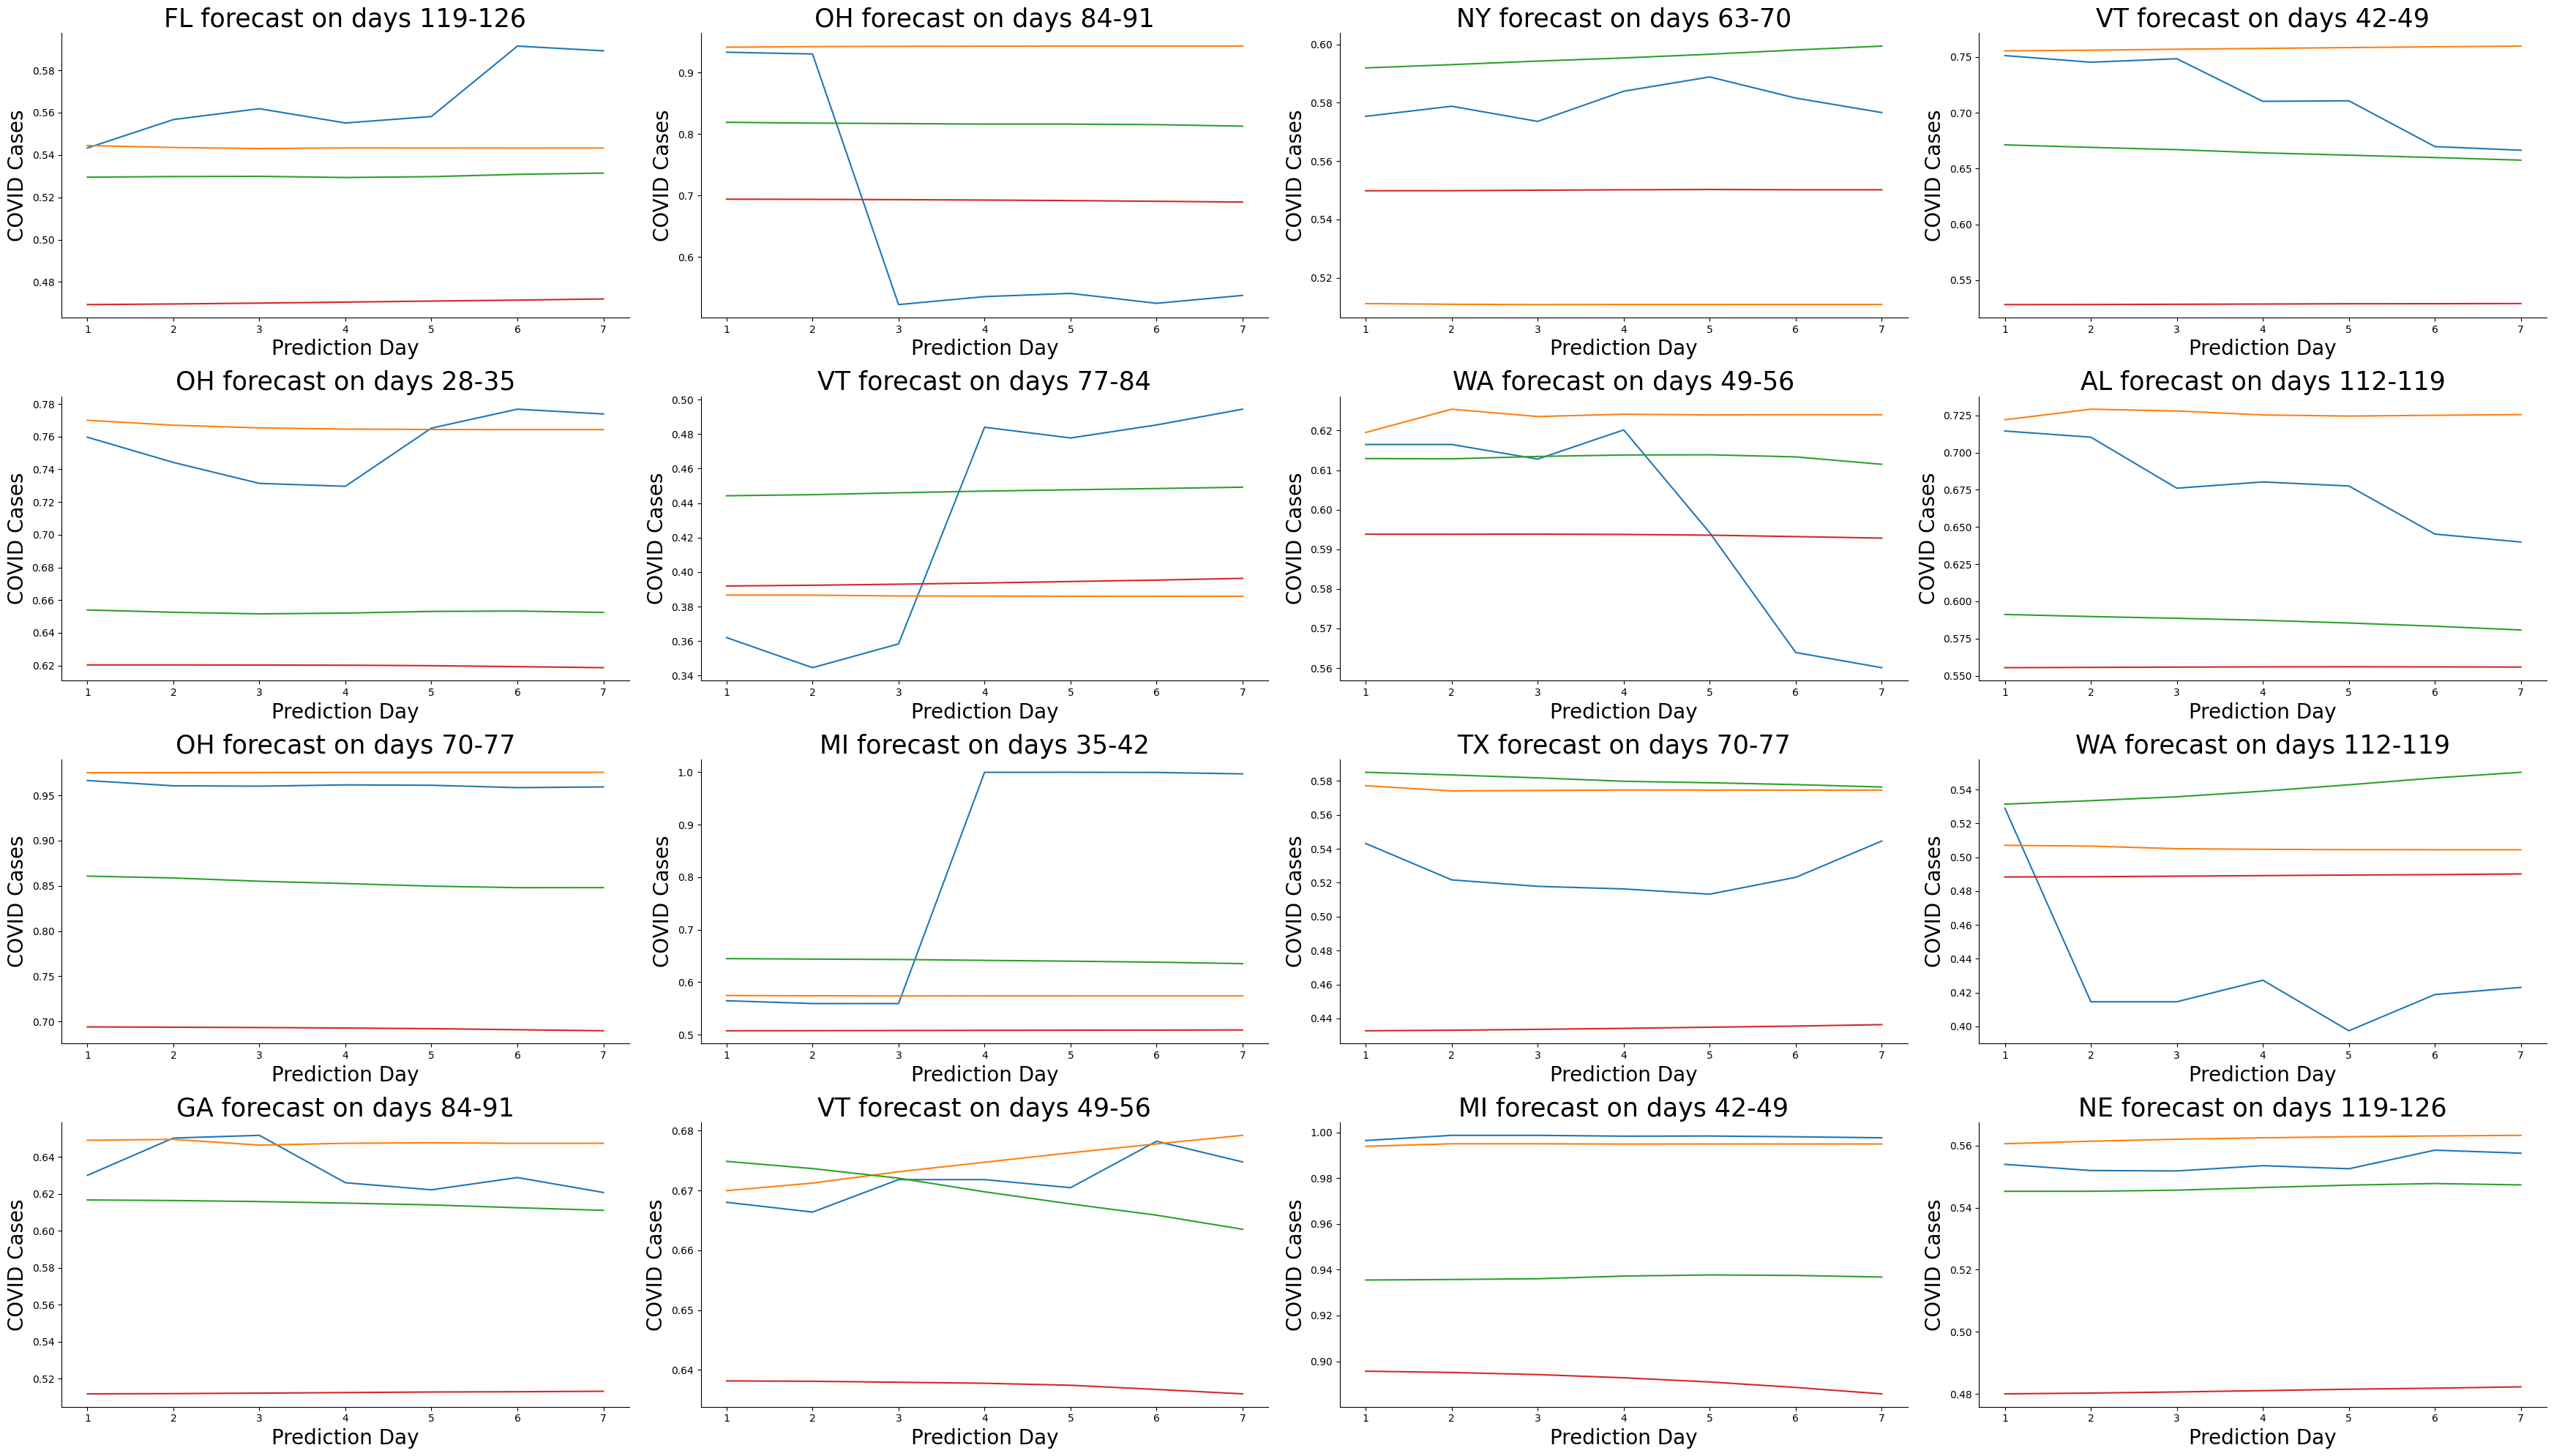

In [21]:
import random
f, ax = plt.subplots(4, 4, figsize=(35, 20))
# Pick 25 random states
states = df.State.unique()
dates = list(range(7, 121, 7))
state = ['AL', 'NE', 'FL', 'WA', 'TX', 'NY', 'NJ', 'MI', 'VT', 'GA', 'OH']


for i in range(4):
    for j in range(4):
        r1 = random.randint(0, len(state)-1)
        r2 = random.randint(0, len(dates)-1)
        s = state[r1]
        d = dates[r2]
        df, test_dates = extend_df(d)
        forecast, losses, plot = forecast_models(df, test_dates, state=s)
        ax[i, j].plot(range(1, 8), forecast['actual'], label='Actual')
        ax[i, j].plot(range(1, 8), forecast['arima'], label=f'ARIMA')
        ax[i, j].plot(range(1, 8), forecast[f'lstm'], label='LSTM average')
        ax[i, j].plot(range(1, 8), forecast[f'gcn'], label='GCN average')

        ax[i, j].set_xlabel('Prediction Day', fontsize=20)
        ax[i, j].set_ylabel('COVID Cases', fontsize=20)
        ax[i, j].spines[['right', 'top']].set_visible(False)
        ax[i, j].set_title(f'{s} forecast on days {d}-{d+7}', fontsize=25)

        if j == 4:
            ax[i, j].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
plt.tight_layout()
plt.savefig('fig.png', dpi=500, bbox_inches='tight')
plt.show()

In [23]:
#lstm
l = [631, 82, 125]
for nc in [3108, 50]:
    for is_ in [21, 28, 35, 42]:
        lstm_no = 0
        for le in l:
            lstm_no += (le - is_) * nc
        print(f"Samples NC{nc}, in size{is_} == {lstm_no}")


Samples NC3108, in size21 == 2408700
Samples NC3108, in size28 == 2343432
Samples NC3108, in size35 == 2278164
Samples NC3108, in size42 == 2212896
Samples NC50, in size21 == 38750
Samples NC50, in size28 == 37700
Samples NC50, in size35 == 36650
Samples NC50, in size42 == 35600


In [ ]:
# Work out most accurate model.
tots = {}
total_mse = {
    'arima_mse': 0,
    'arima_mae': 0,
    'lstm_mse21': 0,
    'lstm_mse28': 0,
    'lstm_mse35': 0,
    'lstm_mse42': 0,
    'lstm_mae21': 0,
    'lstm_mae28': 0,
    'lstm_mae35': 0,
    'lstm_mae42': 0,
    'gcn_mse21': 0,
    'gcn_mse28': 0,
    'gcn_mse35': 0,
    'gcn_mse42': 0,
    'gcn_mae21': 0,
    'gcn_mae28': 0,
    'gcn_mae35': 0,
    'gcn_mae42': 0,
}
i = 0
for n in range(7, 121, 7):
    for state in df.State.unique():
        df, test_dates = extend_df(n) 
        try:
            forecast, losses = forecast_models(df, test_dates, state=state, plot=False)
            i+=1
            for k, v in losses.items():
                total_mse[k] += v
        except:
            pass

for k in total_mse.keys():
    try:
        total_mse[k] /= i
    except:
        pass

print(total_mse)

In [148]:
print(tots)

{'prophet_mse': 1, 'arima_mse': 1}


In [28]:
def forecast_all_models(df, test_dates):
    """
    For every 7 days in the test time period in a state:
      1. Train ARIMA model on dates[:-7] and forecasts dates[-7:].
      2. Train PROPHET model on dates[:-7] and forecasts dates[-7:].
      3. Use pretrained LSTM on window_size :-test days and forecast the next 7 days.
      4. Use pretrained GCN on window_size :-test days and forecast the next 7 days.
      5. Calculate MSE, RMSE, MAE and MAPE loss functions on all forecasts, labelling the plot.
    
    Args:
    - df (pd.DataFrame): dataframe containing all values for training and validation.
    - test_dates (list): columns names within the dataframe of the validation period.
    
    Returns:
    - forecasts: Dictionary containing forecasts for each model
    - losses: Dictionary containing losses for each state/county
    """

    # Filter date columns (assuming format YYYY-MM-DD)
    all_date_cols = [col for col in df.columns if re.match(r'\d{4}-\d{2}-\d{2}', col)]
    train_dates = [col for col in all_date_cols if col not in test_dates]
    test_dates = [col for col in test_dates if re.match(r'\d{4}-\d{2}-\d{2}', col)]
    
    # Group by and then loop over each state
    df_grouped = df.groupby(by=['State'])
    losses = {}
    
    # Create window chunks for test dates (7-day blocks)
    window_size = 7
    windows = [test_dates[i:i+window_size] for i in range(0, len(test_dates), window_size)]
    
    # Initialize forecast dictionaries for each model
    forecasts = {
        'ARIMA': {},
        'PROPHET': {},
        'Actual': {}
    }
    
    for state_name, state_df in df_grouped:
        all_arima_mse = []
        all_arima_mae = []
        all_prophet_mse = []
        all_prophet_mae = []

        state_losses = {}
        num_counties = len(state_df)
        
        # Initialize arrays to store aggregate forecasts for the entire test period
        arima_full_forecast = np.array([])
        prophet_full_forecast = np.array([])
        actual_full = np.array([])
        full_test_dates = []
        
        # Process each 7-day window
        for window_idx, window in enumerate(windows):
            # Calculate how much training data to use
            # For each window, we use all training data plus previously forecasted windows
            current_train_dates = train_dates + test_dates[:window_idx*window_size]
            
            # Initialize arrays for this window's state-level aggregation
            arima_state_forecast = np.zeros((len(window)), dtype=float)
            prophet_state_forecast = np.zeros((len(window)), dtype=float)
            actual_state = np.zeros((len(window)), dtype=float)
            
            # Process each county
            for idx, (_, row) in enumerate(state_df.iterrows()):
                county_name = row['County Name']
                # Extract training and test data for this window
                train_series = row[current_train_dates]
                test_series = row[window]
                
                # Convert to numeric
                train_series = pd.to_numeric(train_series, errors='coerce')
                test_series = pd.to_numeric(test_series, errors='coerce')
                
                # Generate forecasts
                arima_fcst = forecast_arima(train_series, forecast_steps=len(window), order=(2, 1, 1))
                prophet_fcst = forecast_prophet(train_series, forecast_steps=len(window))
                
                # Calculate losses
                arima_mse, arima_mae = calc_losses(arima_fcst, test_series)
                prophet_mse, prophet_mae = calc_losses(prophet_fcst, test_series)
                
                # Store county losses
                if county_name not in state_losses:
                    state_losses[county_name] = {}
                
                window_key = f"window_{window_idx+1}"
                if window_key not in state_losses[county_name]:
                    state_losses[county_name][window_key] = {}
                
                state_losses[county_name][window_key].update({
                    'ARIMA_MSE': arima_mse,
                    'ARIMA_MAE': arima_mae,
                    'PROPHET_MSE': prophet_mse,
                    'PROPHET_MAE': prophet_mae,
                })

                all_arima_mse.append(arima_mse)
                all_arima_mae.append(arima_mae)
                all_prophet_mse.append(prophet_mse)
                all_prophet_mae.append(prophet_mae)
                
                # Aggregate forecasts for state level
                arima_state_forecast += np.array(arima_fcst.values)
                prophet_state_forecast += np.array(prophet_fcst.values)
                actual_state += np.array(test_series.values)
            
            # Average the forecasts across counties
            arima_state_forecast /= num_counties
            prophet_state_forecast /= num_counties
            actual_state /= num_counties
            
            # Append to full forecast arrays
            arima_full_forecast = np.append(arima_full_forecast, arima_state_forecast)
            prophet_full_forecast = np.append(prophet_full_forecast, prophet_state_forecast)
            actual_full = np.append(actual_full, actual_state)
            full_test_dates.extend(window)

            
            
        # Store the state-level forecasts
        forecasts['ARIMA'][state_name] = arima_full_forecast
        forecasts['PROPHET'][state_name] = prophet_full_forecast
        forecasts['Actual'][state_name] = actual_full
        
        # Store losses for this state
        losses[state_name] = state_losses

        x = [datetime.strptime(date, '%Y-%m-%d') for date in full_test_dates]
        
        # Plot the forecasts for this state
        plt.figure(figsize=(12, 6))
        plt.plot(x, arima_full_forecast, label='ARIMA')
        plt.plot(x, prophet_full_forecast, label='PROPHET')
        plt.plot(x, actual_full, label='Actual')
        plt.title(f'COVID Forecasts for {state_name}')
        plt.xlabel('Date')
        plt.ylabel('Cases')
        # Format x-axis to show only month starts, plus start and end dates
        ax = plt.gca()
        
        # Set major ticks to be 1st of each month
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        
        # Ensure the first and last dates are visible
        start_date = x[0]
        end_date = x[-1]
        
        # Get the current ticks
        ticks = ax.get_xticks()
        labels = [datetime.fromordinal(int(t)) for t in ticks]
        
        # Add start and end dates if they're not already included
        if start_date not in labels:
            ticks = np.append([mdates.date2num(start_date)], ticks)
        if end_date not in labels:
            ticks = np.append(ticks, [mdates.date2num(end_date)])
        
        ax.set_xticks(ticks)
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.legend()
        plt.savefig(f'/Users/jakecordery/Desktop/dissertation-york/figures/{state_name}_forecast.pdf', dpi=500, bbox_inches='tight')
        plt.show()
    
        # Calculate average metrics across all counties and windows
        avg_state_metrics = {
            'ARIMA': {
                'MSE': np.mean(all_arima_mse),
                'MAE': np.mean(all_arima_mae)
            },
            'PROPHET': {
                'MSE': np.mean(all_prophet_mse),
                'MAE': np.mean(all_prophet_mae)
            }
        }

        print(f"Average MSE loss ARIMA: {np.mean(all_arima_mse)}")
        print(f"Average MAE loss ARIMA: {np.mean(all_arima_mae)}")
        print(f"Average MSE loss PROPHET: {np.mean(all_prophet_mse)}")
        print(f"Average MAE loss PROPHET: {np.mean(all_prophet_mae)}")
        print(f"Average MSE loss LSTM: ")
        print(f"Average MAE loss LSTM: ")
        print(f"Average MSE loss GCN: ")
        print(f"Average MAE loss GCN: ")

    return forecasts, losses


15:34:07 - cmdstanpy - INFO - Chain [1] start processing
15:34:07 - cmdstanpy - INFO - Chain [1] done processing
15:34:07 - cmdstanpy - INFO - Chain [1] start processing
15:34:07 - cmdstanpy - INFO - Chain [1] done processing
15:34:08 - cmdstanpy - INFO - Chain [1] start processing
15:34:08 - cmdstanpy - INFO - Chain [1] done processing
15:34:08 - cmdstanpy - INFO - Chain [1] start processing
15:34:08 - cmdstanpy - INFO - Chain [1] done processing
15:34:08 - cmdstanpy - INFO - Chain [1] start processing
15:34:08 - cmdstanpy - INFO - Chain [1] done processing
15:34:08 - cmdstanpy - INFO - Chain [1] start processing
15:34:08 - cmdstanpy - INFO - Chain [1] done processing
15:34:08 - cmdstanpy - INFO - Chain [1] start processing
15:34:08 - cmdstanpy - INFO - Chain [1] done processing
15:34:08 - cmdstanpy - INFO - Chain [1] start processing
15:34:08 - cmdstanpy - INFO - Chain [1] done processing
15:34:08 - cmdstanpy - INFO - Chain [1] start processing
15:34:08 - cmdstanpy - INFO - Chain [1]

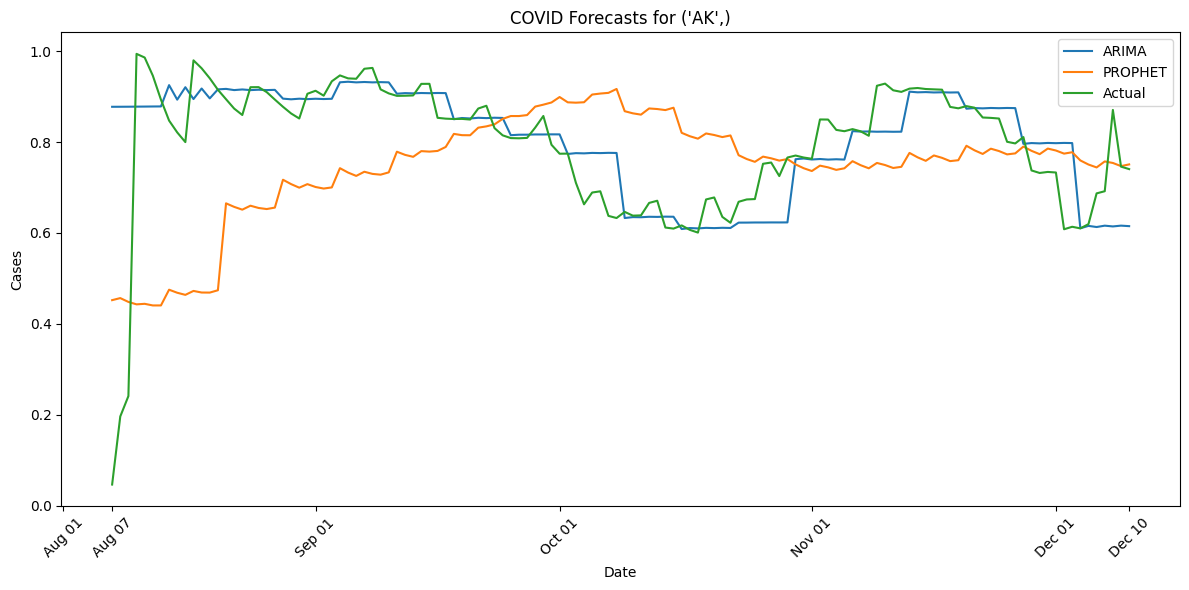

15:35:26 - cmdstanpy - INFO - Chain [1] start processing
15:35:26 - cmdstanpy - INFO - Chain [1] done processing
15:35:26 - cmdstanpy - INFO - Chain [1] start processing
15:35:26 - cmdstanpy - INFO - Chain [1] done processing


Average MSE loss ARIMA: 0.02162205346000155
Average MAE loss ARIMA: 0.06579273226873006
Average MSE loss PROPHET: 0.06507620588982863
Average MAE loss PROPHET: 0.1964246426488999
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


15:35:26 - cmdstanpy - INFO - Chain [1] start processing
15:35:26 - cmdstanpy - INFO - Chain [1] done processing
15:35:26 - cmdstanpy - INFO - Chain [1] start processing
15:35:26 - cmdstanpy - INFO - Chain [1] done processing
15:35:26 - cmdstanpy - INFO - Chain [1] start processing
15:35:26 - cmdstanpy - INFO - Chain [1] done processing
15:35:26 - cmdstanpy - INFO - Chain [1] start processing
15:35:26 - cmdstanpy - INFO - Chain [1] done processing
15:35:26 - cmdstanpy - INFO - Chain [1] start processing
15:35:26 - cmdstanpy - INFO - Chain [1] done processing
15:35:27 - cmdstanpy - INFO - Chain [1] start processing
15:35:27 - cmdstanpy - INFO - Chain [1] done processing
15:35:27 - cmdstanpy - INFO - Chain [1] start processing
15:35:27 - cmdstanpy - INFO - Chain [1] done processing
15:35:27 - cmdstanpy - INFO - Chain [1] start processing
15:35:27 - cmdstanpy - INFO - Chain [1] done processing
15:35:27 - cmdstanpy - INFO - Chain [1] start processing
15:35:27 - cmdstanpy - INFO - Chain [1]

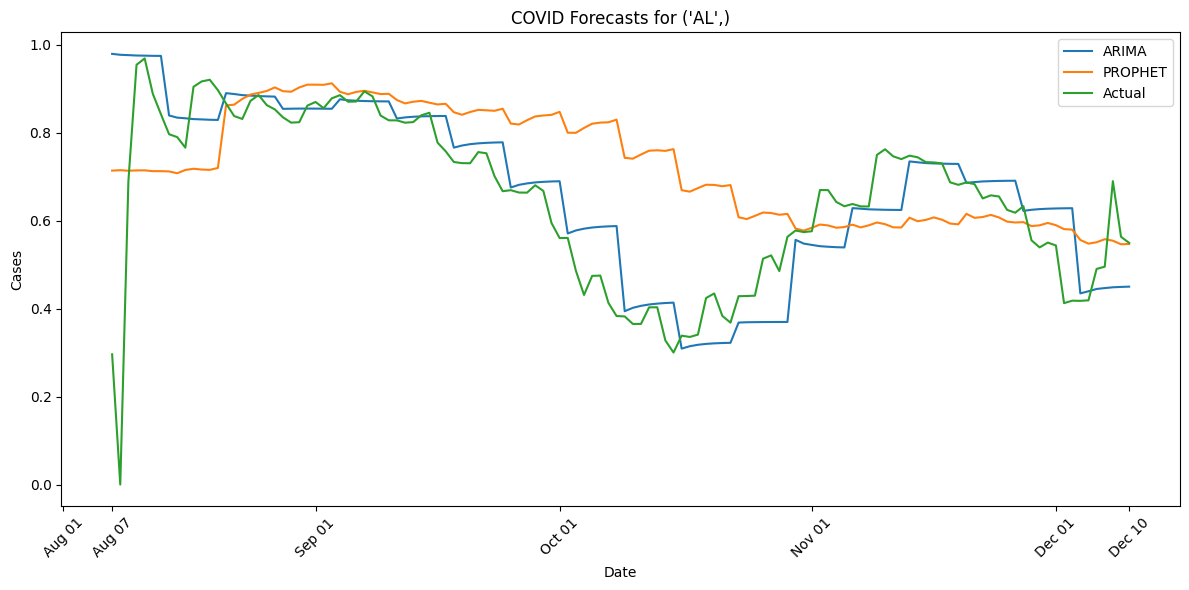

15:38:48 - cmdstanpy - INFO - Chain [1] start processing
15:38:48 - cmdstanpy - INFO - Chain [1] done processing
15:38:49 - cmdstanpy - INFO - Chain [1] start processing
15:38:49 - cmdstanpy - INFO - Chain [1] done processing


Average MSE loss ARIMA: 0.0187418493533707
Average MAE loss ARIMA: 0.07365004522970896
Average MSE loss PROPHET: 0.04151216284224664
Average MAE loss PROPHET: 0.1567996976216135
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


15:38:49 - cmdstanpy - INFO - Chain [1] start processing
15:38:49 - cmdstanpy - INFO - Chain [1] done processing
15:38:49 - cmdstanpy - INFO - Chain [1] start processing
15:38:49 - cmdstanpy - INFO - Chain [1] done processing
15:38:49 - cmdstanpy - INFO - Chain [1] start processing
15:38:49 - cmdstanpy - INFO - Chain [1] done processing
15:38:49 - cmdstanpy - INFO - Chain [1] start processing
15:38:49 - cmdstanpy - INFO - Chain [1] done processing
15:38:49 - cmdstanpy - INFO - Chain [1] start processing
15:38:49 - cmdstanpy - INFO - Chain [1] done processing
15:38:49 - cmdstanpy - INFO - Chain [1] start processing
15:38:49 - cmdstanpy - INFO - Chain [1] done processing
15:38:49 - cmdstanpy - INFO - Chain [1] start processing
15:38:50 - cmdstanpy - INFO - Chain [1] done processing
15:38:50 - cmdstanpy - INFO - Chain [1] start processing
15:38:50 - cmdstanpy - INFO - Chain [1] done processing
15:38:50 - cmdstanpy - INFO - Chain [1] start processing
15:38:50 - cmdstanpy - INFO - Chain [1]

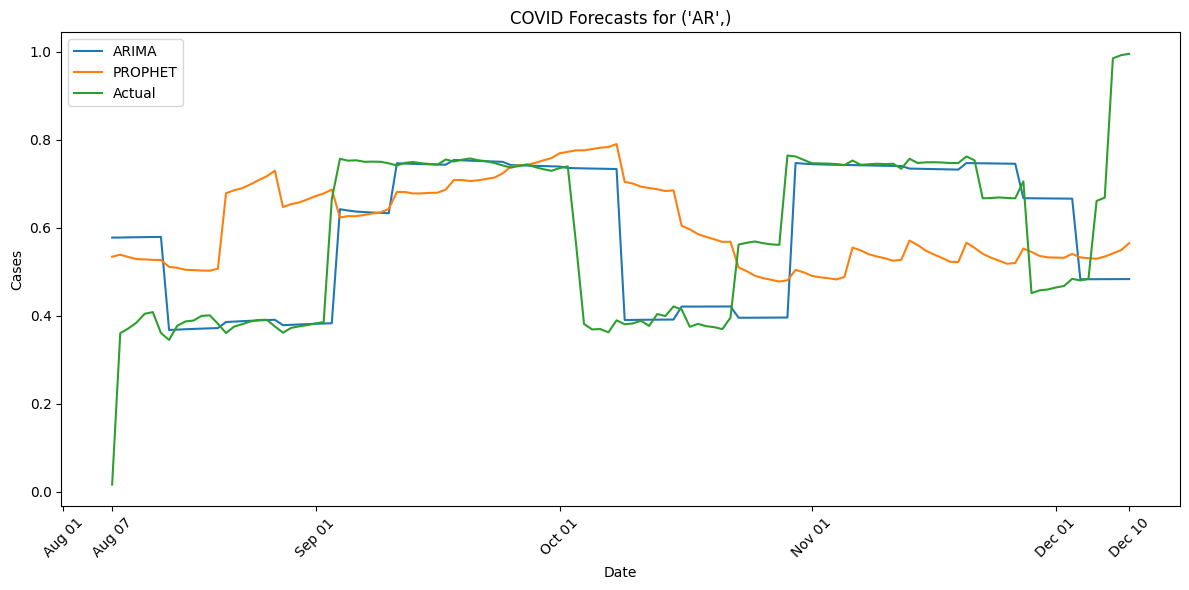

15:42:13 - cmdstanpy - INFO - Chain [1] start processing
15:42:13 - cmdstanpy - INFO - Chain [1] done processing


Average MSE loss ARIMA: 0.0265283407884162
Average MAE loss ARIMA: 0.09121724952021606
Average MSE loss PROPHET: 0.061116674908210655
Average MAE loss PROPHET: 0.2035475931705291
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


15:42:13 - cmdstanpy - INFO - Chain [1] start processing
15:42:13 - cmdstanpy - INFO - Chain [1] done processing
15:42:13 - cmdstanpy - INFO - Chain [1] start processing
15:42:13 - cmdstanpy - INFO - Chain [1] done processing
15:42:13 - cmdstanpy - INFO - Chain [1] start processing
15:42:13 - cmdstanpy - INFO - Chain [1] done processing
15:42:13 - cmdstanpy - INFO - Chain [1] start processing
15:42:13 - cmdstanpy - INFO - Chain [1] done processing
15:42:13 - cmdstanpy - INFO - Chain [1] start processing
15:42:13 - cmdstanpy - INFO - Chain [1] done processing
15:42:14 - cmdstanpy - INFO - Chain [1] start processing
15:42:14 - cmdstanpy - INFO - Chain [1] done processing
15:42:14 - cmdstanpy - INFO - Chain [1] start processing
15:42:14 - cmdstanpy - INFO - Chain [1] done processing
15:42:14 - cmdstanpy - INFO - Chain [1] start processing
15:42:14 - cmdstanpy - INFO - Chain [1] done processing
15:42:14 - cmdstanpy - INFO - Chain [1] start processing
15:42:14 - cmdstanpy - INFO - Chain [1]

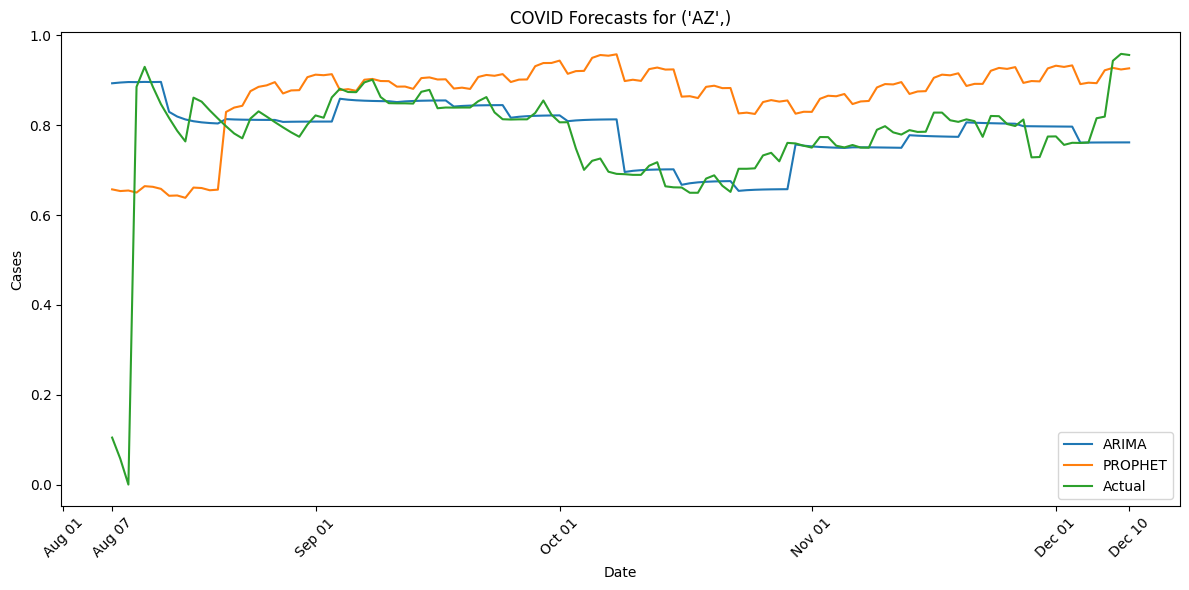

15:43:01 - cmdstanpy - INFO - Chain [1] start processing
15:43:01 - cmdstanpy - INFO - Chain [1] done processing
15:43:01 - cmdstanpy - INFO - Chain [1] start processing


Average MSE loss ARIMA: 0.021020163795298488
Average MAE loss ARIMA: 0.05611639035218256
Average MSE loss PROPHET: 0.03869197215087025
Average MAE loss PROPHET: 0.16211735878895311
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


15:43:01 - cmdstanpy - INFO - Chain [1] done processing
15:43:01 - cmdstanpy - INFO - Chain [1] start processing
15:43:01 - cmdstanpy - INFO - Chain [1] done processing
15:43:02 - cmdstanpy - INFO - Chain [1] start processing
15:43:02 - cmdstanpy - INFO - Chain [1] done processing
15:43:02 - cmdstanpy - INFO - Chain [1] start processing
15:43:02 - cmdstanpy - INFO - Chain [1] done processing
15:43:02 - cmdstanpy - INFO - Chain [1] start processing
15:43:02 - cmdstanpy - INFO - Chain [1] done processing
15:43:02 - cmdstanpy - INFO - Chain [1] start processing
15:43:02 - cmdstanpy - INFO - Chain [1] done processing
15:43:02 - cmdstanpy - INFO - Chain [1] start processing
15:43:02 - cmdstanpy - INFO - Chain [1] done processing
15:43:02 - cmdstanpy - INFO - Chain [1] start processing
15:43:02 - cmdstanpy - INFO - Chain [1] done processing
15:43:02 - cmdstanpy - INFO - Chain [1] start processing
15:43:02 - cmdstanpy - INFO - Chain [1] done processing
15:43:02 - cmdstanpy - INFO - Chain [1] 

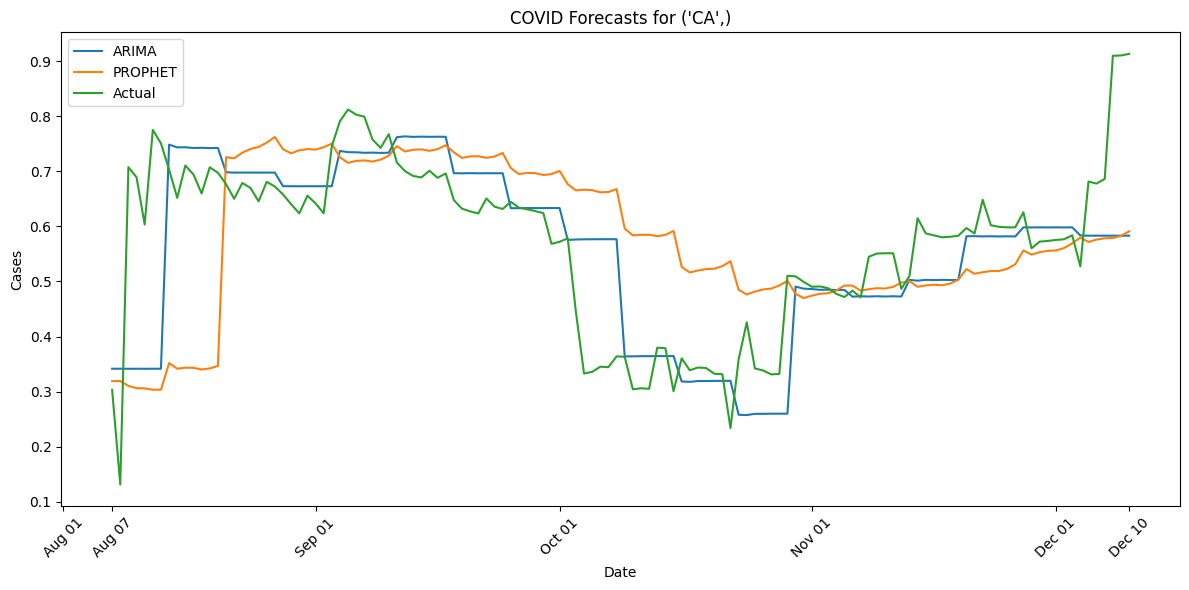

15:45:50 - cmdstanpy - INFO - Chain [1] start processing
15:45:50 - cmdstanpy - INFO - Chain [1] done processing
15:45:50 - cmdstanpy - INFO - Chain [1] start processing
15:45:50 - cmdstanpy - INFO - Chain [1] done processing


Average MSE loss ARIMA: 0.027883388492635303
Average MAE loss ARIMA: 0.09753253391444237
Average MSE loss PROPHET: 0.06730110425114025
Average MAE loss PROPHET: 0.19396564202943348
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


15:45:50 - cmdstanpy - INFO - Chain [1] start processing
15:45:50 - cmdstanpy - INFO - Chain [1] done processing
15:45:50 - cmdstanpy - INFO - Chain [1] start processing
15:45:50 - cmdstanpy - INFO - Chain [1] done processing
15:45:50 - cmdstanpy - INFO - Chain [1] start processing
15:45:51 - cmdstanpy - INFO - Chain [1] done processing
15:45:51 - cmdstanpy - INFO - Chain [1] start processing
15:45:51 - cmdstanpy - INFO - Chain [1] done processing
15:45:51 - cmdstanpy - INFO - Chain [1] start processing
15:45:51 - cmdstanpy - INFO - Chain [1] done processing
15:45:51 - cmdstanpy - INFO - Chain [1] start processing
15:45:51 - cmdstanpy - INFO - Chain [1] done processing
15:45:51 - cmdstanpy - INFO - Chain [1] start processing
15:45:51 - cmdstanpy - INFO - Chain [1] done processing
15:45:51 - cmdstanpy - INFO - Chain [1] start processing
15:45:51 - cmdstanpy - INFO - Chain [1] done processing
15:45:51 - cmdstanpy - INFO - Chain [1] start processing
15:45:51 - cmdstanpy - INFO - Chain [1]

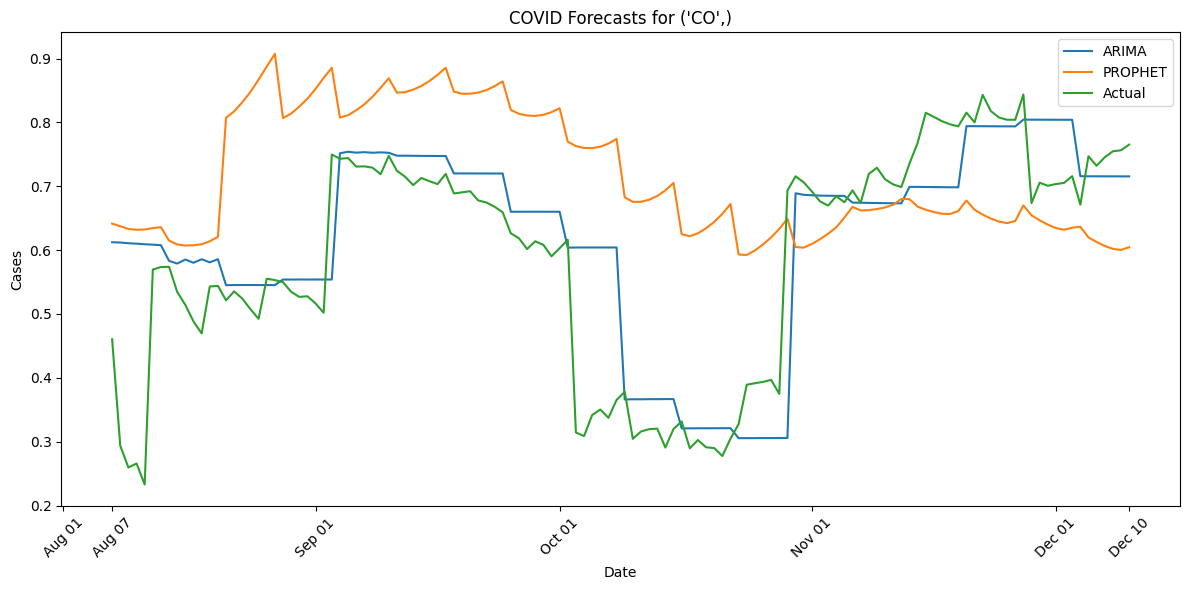

15:48:52 - cmdstanpy - INFO - Chain [1] start processing
15:48:52 - cmdstanpy - INFO - Chain [1] done processing
15:48:52 - cmdstanpy - INFO - Chain [1] start processing


Average MSE loss ARIMA: 0.021389893913132854
Average MAE loss ARIMA: 0.08716706734885486
Average MSE loss PROPHET: 0.07960837352735457
Average MAE loss PROPHET: 0.23910597820199384
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


15:48:52 - cmdstanpy - INFO - Chain [1] done processing
15:48:52 - cmdstanpy - INFO - Chain [1] start processing
15:48:52 - cmdstanpy - INFO - Chain [1] done processing
15:48:52 - cmdstanpy - INFO - Chain [1] start processing
15:48:52 - cmdstanpy - INFO - Chain [1] done processing
15:48:52 - cmdstanpy - INFO - Chain [1] start processing
15:48:52 - cmdstanpy - INFO - Chain [1] done processing
15:48:52 - cmdstanpy - INFO - Chain [1] start processing
15:48:52 - cmdstanpy - INFO - Chain [1] done processing
15:48:53 - cmdstanpy - INFO - Chain [1] start processing
15:48:53 - cmdstanpy - INFO - Chain [1] done processing
15:48:53 - cmdstanpy - INFO - Chain [1] start processing
15:48:53 - cmdstanpy - INFO - Chain [1] done processing
15:48:53 - cmdstanpy - INFO - Chain [1] start processing
15:48:53 - cmdstanpy - INFO - Chain [1] done processing
15:48:53 - cmdstanpy - INFO - Chain [1] start processing
15:48:53 - cmdstanpy - INFO - Chain [1] done processing
15:48:53 - cmdstanpy - INFO - Chain [1] 

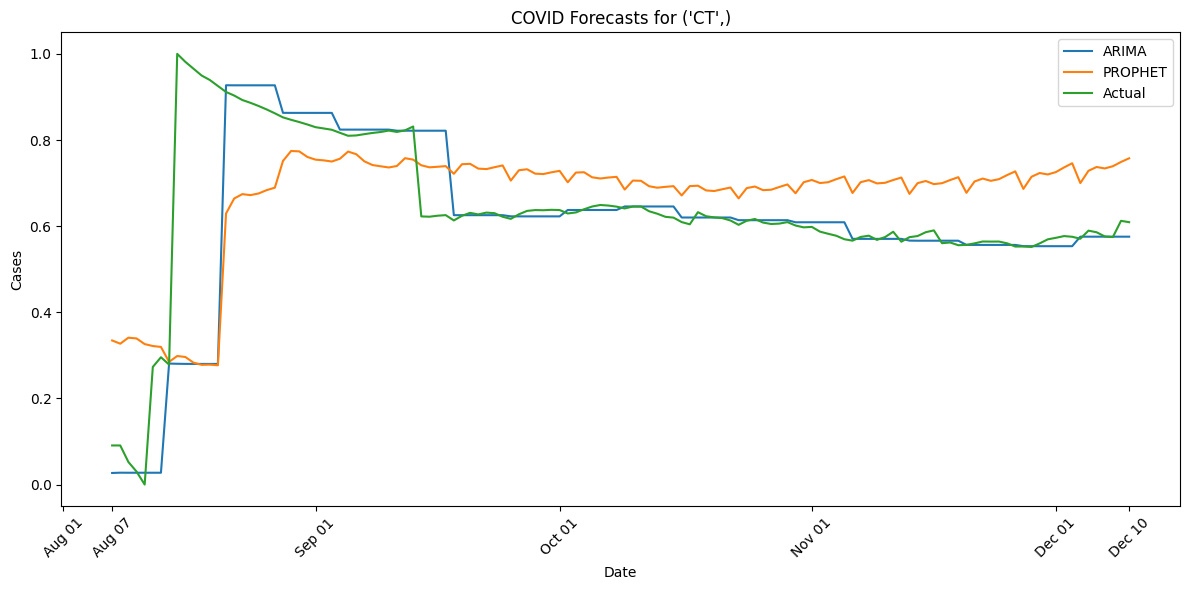

15:49:15 - cmdstanpy - INFO - Chain [1] start processing
15:49:15 - cmdstanpy - INFO - Chain [1] done processing
15:49:15 - cmdstanpy - INFO - Chain [1] start processing


Average MSE loss ARIMA: 0.025006409213200582
Average MAE loss ARIMA: 0.05612338085440021
Average MSE loss PROPHET: 0.03980145435456332
Average MAE loss PROPHET: 0.14344747294090318
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


15:49:15 - cmdstanpy - INFO - Chain [1] done processing
15:49:16 - cmdstanpy - INFO - Chain [1] start processing
15:49:16 - cmdstanpy - INFO - Chain [1] done processing
15:49:16 - cmdstanpy - INFO - Chain [1] start processing
15:49:16 - cmdstanpy - INFO - Chain [1] done processing
15:49:16 - cmdstanpy - INFO - Chain [1] start processing
15:49:16 - cmdstanpy - INFO - Chain [1] done processing
15:49:16 - cmdstanpy - INFO - Chain [1] start processing
15:49:16 - cmdstanpy - INFO - Chain [1] done processing
15:49:16 - cmdstanpy - INFO - Chain [1] start processing
15:49:16 - cmdstanpy - INFO - Chain [1] done processing
15:49:16 - cmdstanpy - INFO - Chain [1] start processing
15:49:16 - cmdstanpy - INFO - Chain [1] done processing
15:49:16 - cmdstanpy - INFO - Chain [1] start processing
15:49:17 - cmdstanpy - INFO - Chain [1] done processing
15:49:17 - cmdstanpy - INFO - Chain [1] start processing
15:49:17 - cmdstanpy - INFO - Chain [1] done processing
15:49:17 - cmdstanpy - INFO - Chain [1] 

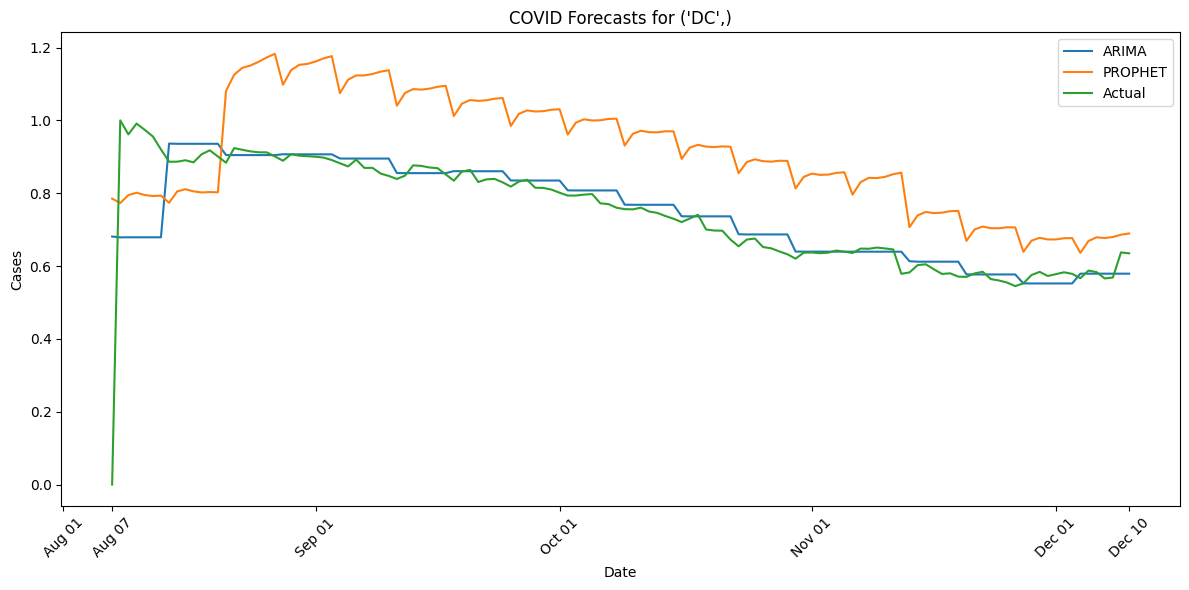

15:49:18 - cmdstanpy - INFO - Chain [1] start processing
15:49:18 - cmdstanpy - INFO - Chain [1] done processing
15:49:18 - cmdstanpy - INFO - Chain [1] start processing


Average MSE loss ARIMA: 0.00828956514636355
Average MAE loss ARIMA: 0.038465473107599735
Average MSE loss PROPHET: 0.04318180532372115
Average MAE loss PROPHET: 0.19282563080643253
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


15:49:18 - cmdstanpy - INFO - Chain [1] done processing
15:49:19 - cmdstanpy - INFO - Chain [1] start processing
15:49:19 - cmdstanpy - INFO - Chain [1] done processing
15:49:19 - cmdstanpy - INFO - Chain [1] start processing
15:49:19 - cmdstanpy - INFO - Chain [1] done processing
15:49:19 - cmdstanpy - INFO - Chain [1] start processing
15:49:19 - cmdstanpy - INFO - Chain [1] done processing
15:49:19 - cmdstanpy - INFO - Chain [1] start processing
15:49:19 - cmdstanpy - INFO - Chain [1] done processing
15:49:19 - cmdstanpy - INFO - Chain [1] start processing
15:49:19 - cmdstanpy - INFO - Chain [1] done processing
15:49:19 - cmdstanpy - INFO - Chain [1] start processing
15:49:19 - cmdstanpy - INFO - Chain [1] done processing
15:49:20 - cmdstanpy - INFO - Chain [1] start processing
15:49:20 - cmdstanpy - INFO - Chain [1] done processing
15:49:20 - cmdstanpy - INFO - Chain [1] start processing
15:49:20 - cmdstanpy - INFO - Chain [1] done processing
15:49:20 - cmdstanpy - INFO - Chain [1] 

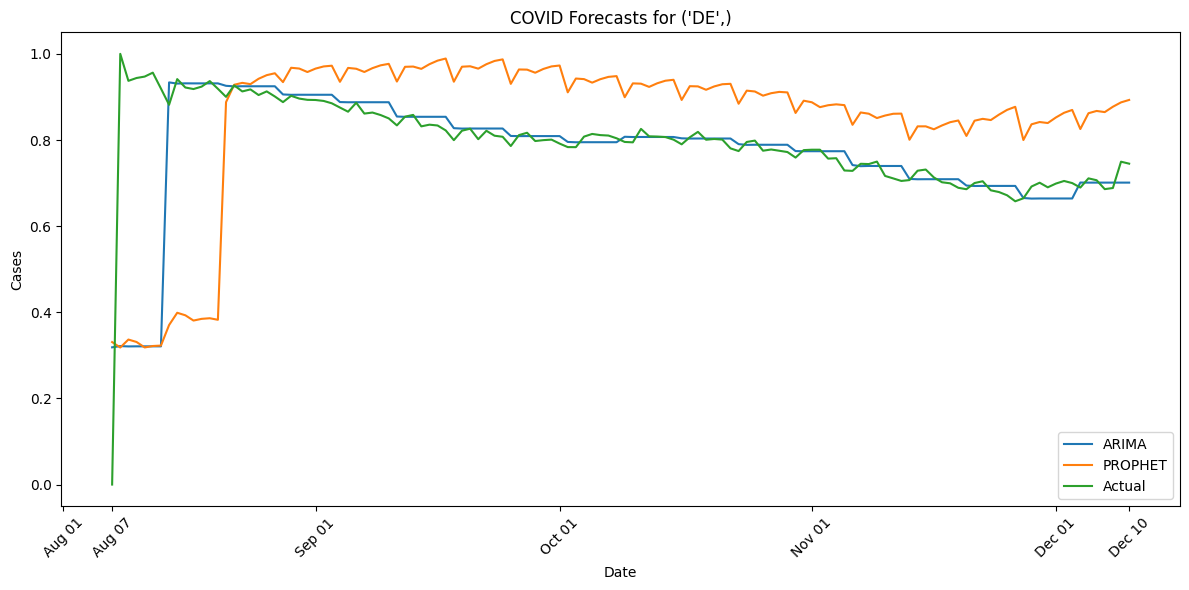

15:49:27 - cmdstanpy - INFO - Chain [1] start processing
15:49:27 - cmdstanpy - INFO - Chain [1] done processing
15:49:27 - cmdstanpy - INFO - Chain [1] start processing


Average MSE loss ARIMA: 0.02130624022733663
Average MAE loss ARIMA: 0.048042359544137714
Average MSE loss PROPHET: 0.055073976145835514
Average MAE loss PROPHET: 0.17519901898305767
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


15:49:27 - cmdstanpy - INFO - Chain [1] done processing
15:49:27 - cmdstanpy - INFO - Chain [1] start processing
15:49:27 - cmdstanpy - INFO - Chain [1] done processing
15:49:27 - cmdstanpy - INFO - Chain [1] start processing
15:49:27 - cmdstanpy - INFO - Chain [1] done processing
15:49:27 - cmdstanpy - INFO - Chain [1] start processing
15:49:27 - cmdstanpy - INFO - Chain [1] done processing
15:49:28 - cmdstanpy - INFO - Chain [1] start processing
15:49:28 - cmdstanpy - INFO - Chain [1] done processing
15:49:28 - cmdstanpy - INFO - Chain [1] start processing
15:49:28 - cmdstanpy - INFO - Chain [1] done processing
15:49:28 - cmdstanpy - INFO - Chain [1] start processing
15:49:28 - cmdstanpy - INFO - Chain [1] done processing
15:49:28 - cmdstanpy - INFO - Chain [1] start processing
15:49:28 - cmdstanpy - INFO - Chain [1] done processing
15:49:28 - cmdstanpy - INFO - Chain [1] start processing
15:49:28 - cmdstanpy - INFO - Chain [1] done processing
15:49:28 - cmdstanpy - INFO - Chain [1] 

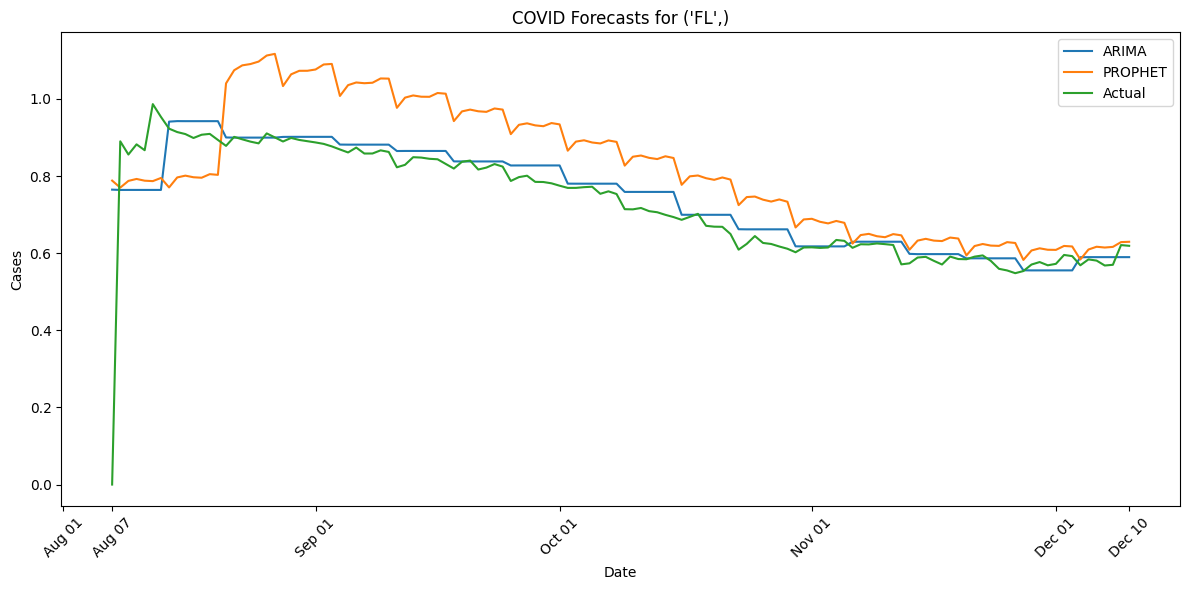

15:52:39 - cmdstanpy - INFO - Chain [1] start processing
15:52:39 - cmdstanpy - INFO - Chain [1] done processing
15:52:39 - cmdstanpy - INFO - Chain [1] start processing


Average MSE loss ARIMA: 0.007750362977841105
Average MAE loss ARIMA: 0.03837275863671115
Average MSE loss PROPHET: 0.023092750980525205
Average MAE loss PROPHET: 0.11969552479872912
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


15:52:39 - cmdstanpy - INFO - Chain [1] done processing
15:52:39 - cmdstanpy - INFO - Chain [1] start processing
15:52:39 - cmdstanpy - INFO - Chain [1] done processing
15:52:39 - cmdstanpy - INFO - Chain [1] start processing
15:52:39 - cmdstanpy - INFO - Chain [1] done processing
15:52:39 - cmdstanpy - INFO - Chain [1] start processing
15:52:39 - cmdstanpy - INFO - Chain [1] done processing
15:52:39 - cmdstanpy - INFO - Chain [1] start processing
15:52:39 - cmdstanpy - INFO - Chain [1] done processing
15:52:39 - cmdstanpy - INFO - Chain [1] start processing
15:52:39 - cmdstanpy - INFO - Chain [1] done processing
15:52:40 - cmdstanpy - INFO - Chain [1] start processing
15:52:40 - cmdstanpy - INFO - Chain [1] done processing
15:52:40 - cmdstanpy - INFO - Chain [1] start processing
15:52:40 - cmdstanpy - INFO - Chain [1] done processing
15:52:40 - cmdstanpy - INFO - Chain [1] start processing
15:52:40 - cmdstanpy - INFO - Chain [1] done processing
15:52:40 - cmdstanpy - INFO - Chain [1] 

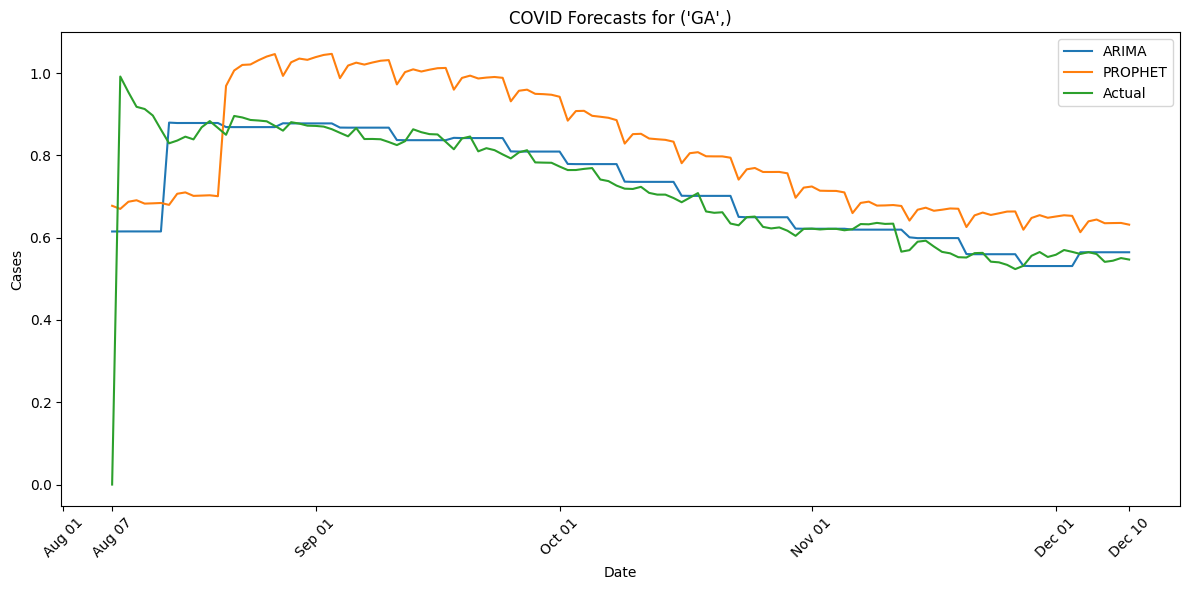

15:59:52 - cmdstanpy - INFO - Chain [1] start processing
15:59:52 - cmdstanpy - INFO - Chain [1] done processing
15:59:52 - cmdstanpy - INFO - Chain [1] start processing


Average MSE loss ARIMA: 0.008492050875739138
Average MAE loss ARIMA: 0.03952684810851275
Average MSE loss PROPHET: 0.02569553238754462
Average MAE loss PROPHET: 0.138920411470412
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


15:59:52 - cmdstanpy - INFO - Chain [1] done processing
15:59:52 - cmdstanpy - INFO - Chain [1] start processing
15:59:53 - cmdstanpy - INFO - Chain [1] done processing
15:59:53 - cmdstanpy - INFO - Chain [1] start processing
15:59:53 - cmdstanpy - INFO - Chain [1] done processing
15:59:53 - cmdstanpy - INFO - Chain [1] start processing
15:59:53 - cmdstanpy - INFO - Chain [1] done processing
15:59:53 - cmdstanpy - INFO - Chain [1] start processing
15:59:53 - cmdstanpy - INFO - Chain [1] done processing
15:59:53 - cmdstanpy - INFO - Chain [1] start processing
15:59:53 - cmdstanpy - INFO - Chain [1] done processing
15:59:53 - cmdstanpy - INFO - Chain [1] start processing
15:59:53 - cmdstanpy - INFO - Chain [1] done processing
15:59:53 - cmdstanpy - INFO - Chain [1] start processing
15:59:53 - cmdstanpy - INFO - Chain [1] done processing
15:59:53 - cmdstanpy - INFO - Chain [1] start processing
15:59:53 - cmdstanpy - INFO - Chain [1] done processing
15:59:54 - cmdstanpy - INFO - Chain [1] 

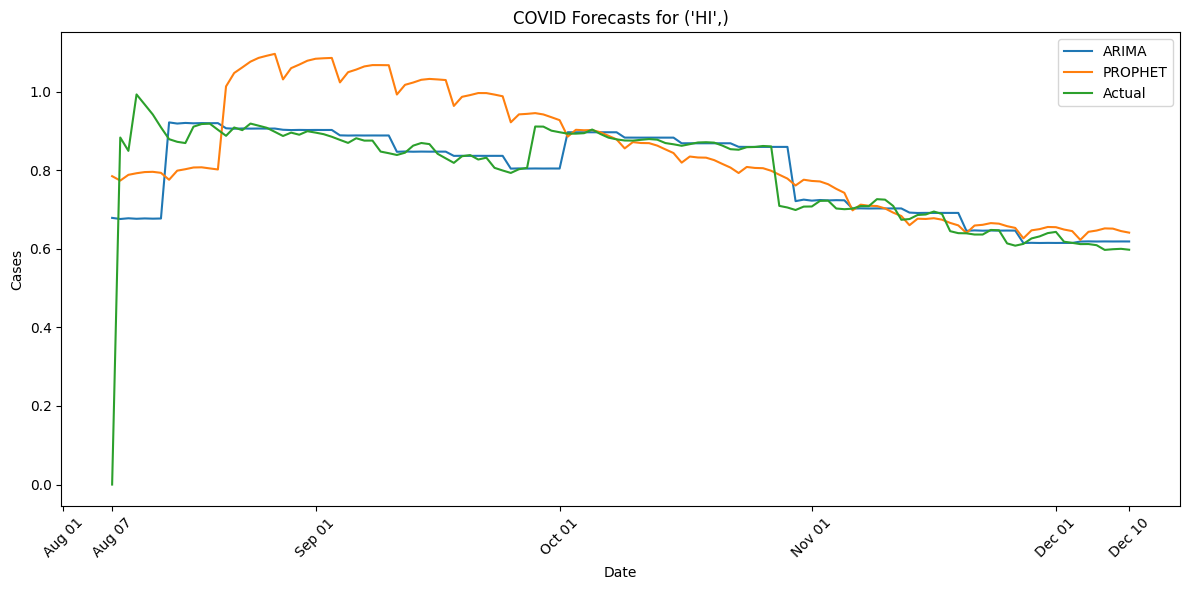

16:00:06 - cmdstanpy - INFO - Chain [1] start processing
16:00:06 - cmdstanpy - INFO - Chain [1] done processing


Average MSE loss ARIMA: 0.00819200762778771
Average MAE loss ARIMA: 0.037038469784751483
Average MSE loss PROPHET: 0.019059434377009594
Average MAE loss PROPHET: 0.09940322623762553
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


16:00:06 - cmdstanpy - INFO - Chain [1] start processing
16:00:06 - cmdstanpy - INFO - Chain [1] done processing
16:00:06 - cmdstanpy - INFO - Chain [1] start processing
16:00:06 - cmdstanpy - INFO - Chain [1] done processing
16:00:07 - cmdstanpy - INFO - Chain [1] start processing
16:00:07 - cmdstanpy - INFO - Chain [1] done processing
16:00:07 - cmdstanpy - INFO - Chain [1] start processing
16:00:07 - cmdstanpy - INFO - Chain [1] done processing
16:00:07 - cmdstanpy - INFO - Chain [1] start processing
16:00:07 - cmdstanpy - INFO - Chain [1] done processing
16:00:07 - cmdstanpy - INFO - Chain [1] start processing
16:00:07 - cmdstanpy - INFO - Chain [1] done processing
16:00:07 - cmdstanpy - INFO - Chain [1] start processing
16:00:07 - cmdstanpy - INFO - Chain [1] done processing
16:00:07 - cmdstanpy - INFO - Chain [1] start processing
16:00:07 - cmdstanpy - INFO - Chain [1] done processing
16:00:07 - cmdstanpy - INFO - Chain [1] start processing
16:00:07 - cmdstanpy - INFO - Chain [1]

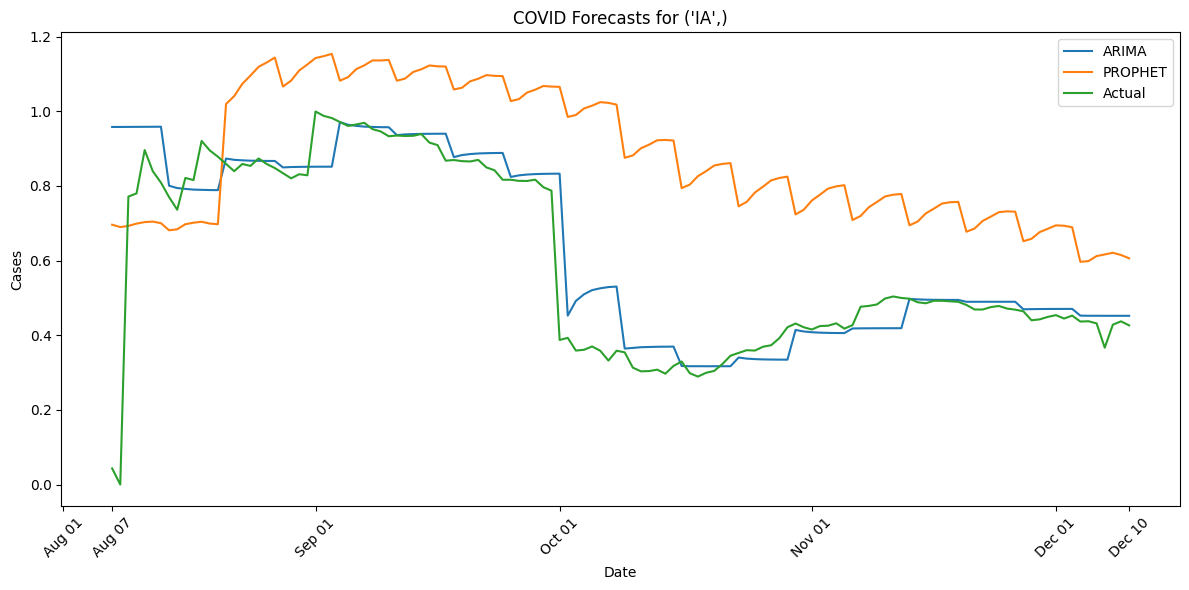

16:04:54 - cmdstanpy - INFO - Chain [1] start processing
16:04:54 - cmdstanpy - INFO - Chain [1] done processing


Average MSE loss ARIMA: 0.019746743308538147
Average MAE loss ARIMA: 0.060535340250380376
Average MSE loss PROPHET: 0.12056879402945667
Average MAE loss PROPHET: 0.3022811267498273
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


16:04:54 - cmdstanpy - INFO - Chain [1] start processing
16:04:54 - cmdstanpy - INFO - Chain [1] done processing
16:04:55 - cmdstanpy - INFO - Chain [1] start processing
16:04:55 - cmdstanpy - INFO - Chain [1] done processing
16:04:55 - cmdstanpy - INFO - Chain [1] start processing
16:04:55 - cmdstanpy - INFO - Chain [1] done processing
16:04:55 - cmdstanpy - INFO - Chain [1] start processing
16:04:55 - cmdstanpy - INFO - Chain [1] done processing
16:04:55 - cmdstanpy - INFO - Chain [1] start processing
16:04:55 - cmdstanpy - INFO - Chain [1] done processing
16:04:55 - cmdstanpy - INFO - Chain [1] start processing
16:04:55 - cmdstanpy - INFO - Chain [1] done processing
16:04:55 - cmdstanpy - INFO - Chain [1] start processing
16:04:55 - cmdstanpy - INFO - Chain [1] done processing
16:04:55 - cmdstanpy - INFO - Chain [1] start processing
16:04:56 - cmdstanpy - INFO - Chain [1] done processing
16:04:56 - cmdstanpy - INFO - Chain [1] start processing
16:04:56 - cmdstanpy - INFO - Chain [1]

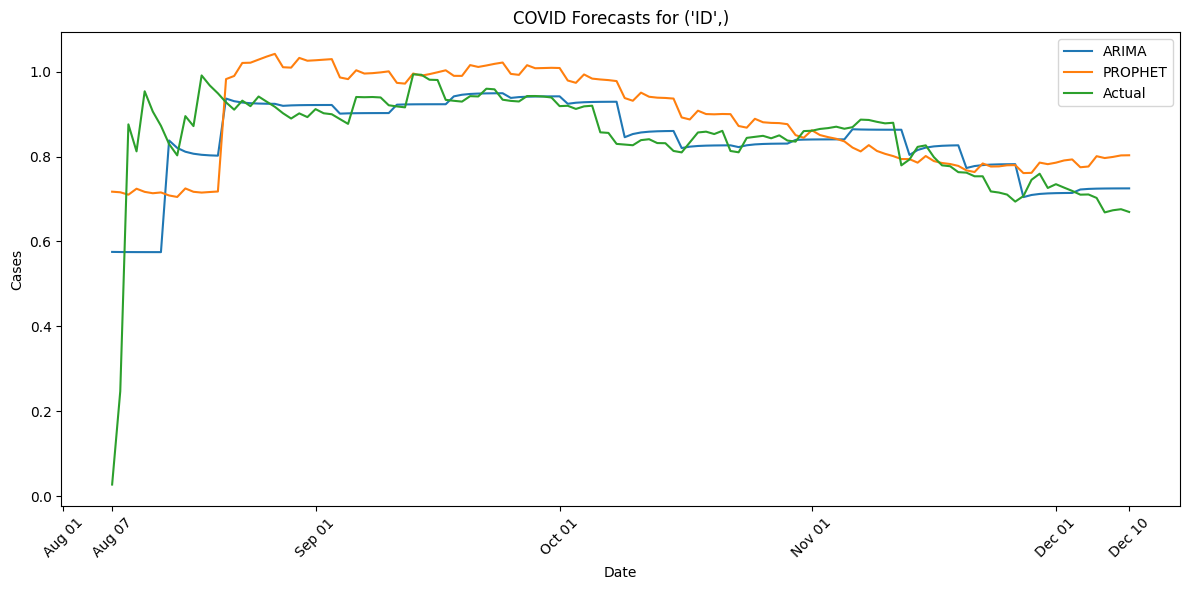

16:07:08 - cmdstanpy - INFO - Chain [1] start processing


Average MSE loss ARIMA: 0.009738701897303453
Average MAE loss ARIMA: 0.04826939035197212
Average MSE loss PROPHET: 0.017024969686599944
Average MAE loss PROPHET: 0.09341443266796294
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


16:07:08 - cmdstanpy - INFO - Chain [1] done processing
16:07:08 - cmdstanpy - INFO - Chain [1] start processing
16:07:08 - cmdstanpy - INFO - Chain [1] done processing
16:07:08 - cmdstanpy - INFO - Chain [1] start processing
16:07:08 - cmdstanpy - INFO - Chain [1] done processing
16:07:09 - cmdstanpy - INFO - Chain [1] start processing
16:07:09 - cmdstanpy - INFO - Chain [1] done processing
16:07:09 - cmdstanpy - INFO - Chain [1] start processing
16:07:09 - cmdstanpy - INFO - Chain [1] done processing
16:07:09 - cmdstanpy - INFO - Chain [1] start processing
16:07:09 - cmdstanpy - INFO - Chain [1] done processing
16:07:09 - cmdstanpy - INFO - Chain [1] start processing
16:07:09 - cmdstanpy - INFO - Chain [1] done processing
16:07:09 - cmdstanpy - INFO - Chain [1] start processing
16:07:09 - cmdstanpy - INFO - Chain [1] done processing
16:07:09 - cmdstanpy - INFO - Chain [1] start processing
16:07:09 - cmdstanpy - INFO - Chain [1] done processing
16:07:09 - cmdstanpy - INFO - Chain [1] 

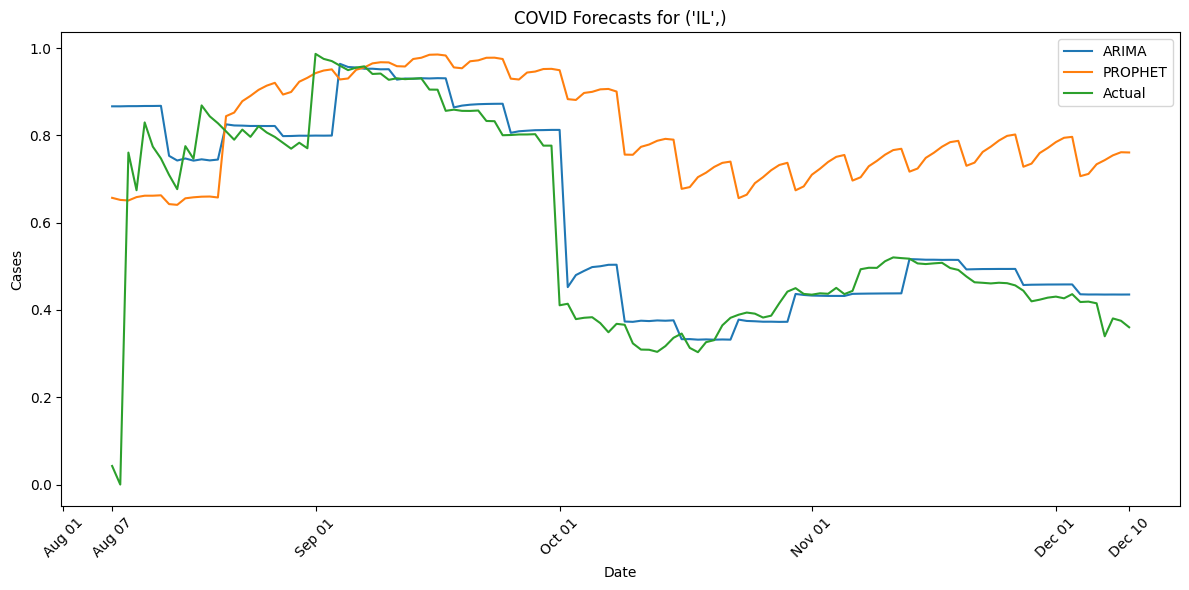

16:12:14 - cmdstanpy - INFO - Chain [1] start processing
16:12:14 - cmdstanpy - INFO - Chain [1] done processing


Average MSE loss ARIMA: 0.01940449143342282
Average MAE loss ARIMA: 0.0643001237591153
Average MSE loss PROPHET: 0.09877734538841845
Average MAE loss PROPHET: 0.26441539344623366
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


16:12:14 - cmdstanpy - INFO - Chain [1] start processing
16:12:14 - cmdstanpy - INFO - Chain [1] done processing
16:12:14 - cmdstanpy - INFO - Chain [1] start processing
16:12:14 - cmdstanpy - INFO - Chain [1] done processing
16:12:14 - cmdstanpy - INFO - Chain [1] start processing
16:12:14 - cmdstanpy - INFO - Chain [1] done processing
16:12:14 - cmdstanpy - INFO - Chain [1] start processing
16:12:14 - cmdstanpy - INFO - Chain [1] done processing
16:12:14 - cmdstanpy - INFO - Chain [1] start processing
16:12:14 - cmdstanpy - INFO - Chain [1] done processing
16:12:15 - cmdstanpy - INFO - Chain [1] start processing
16:12:15 - cmdstanpy - INFO - Chain [1] done processing
16:12:15 - cmdstanpy - INFO - Chain [1] start processing
16:12:15 - cmdstanpy - INFO - Chain [1] done processing
16:12:15 - cmdstanpy - INFO - Chain [1] start processing
16:12:15 - cmdstanpy - INFO - Chain [1] done processing
16:12:15 - cmdstanpy - INFO - Chain [1] start processing
16:12:15 - cmdstanpy - INFO - Chain [1]

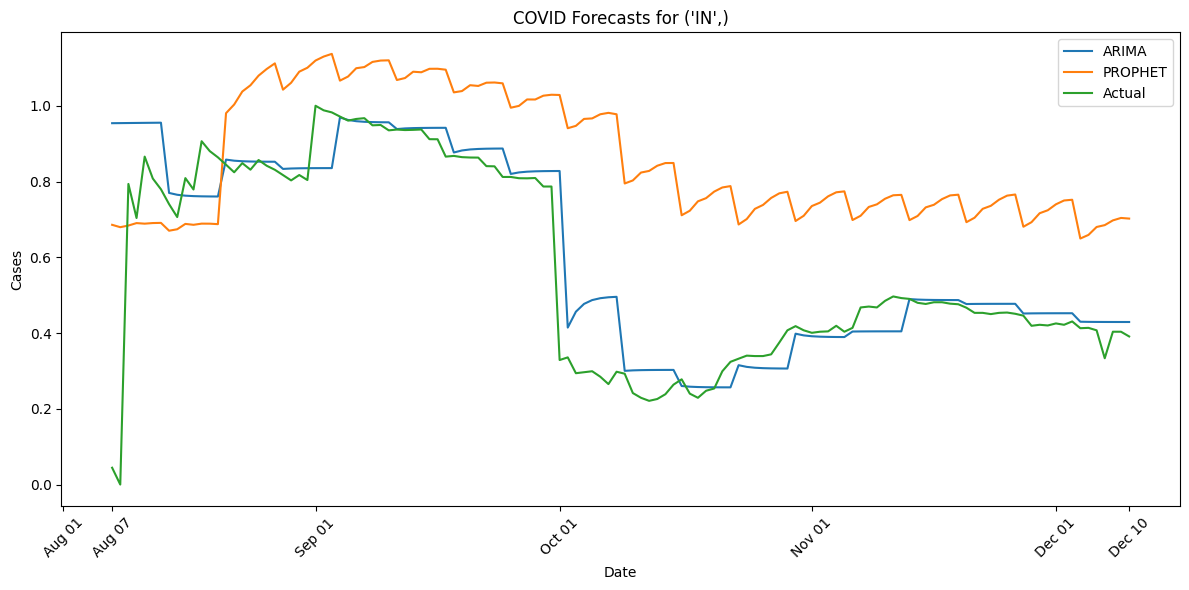

16:16:41 - cmdstanpy - INFO - Chain [1] start processing
16:16:41 - cmdstanpy - INFO - Chain [1] done processing


Average MSE loss ARIMA: 0.02095452932554315
Average MAE loss ARIMA: 0.06600610995855047
Average MSE loss PROPHET: 0.12243477145247639
Average MAE loss PROPHET: 0.3034430878190701
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


16:16:41 - cmdstanpy - INFO - Chain [1] start processing
16:16:41 - cmdstanpy - INFO - Chain [1] done processing
16:16:41 - cmdstanpy - INFO - Chain [1] start processing
16:16:41 - cmdstanpy - INFO - Chain [1] done processing
16:16:42 - cmdstanpy - INFO - Chain [1] start processing
16:16:42 - cmdstanpy - INFO - Chain [1] done processing
16:16:42 - cmdstanpy - INFO - Chain [1] start processing
16:16:42 - cmdstanpy - INFO - Chain [1] done processing
16:16:42 - cmdstanpy - INFO - Chain [1] start processing
16:16:42 - cmdstanpy - INFO - Chain [1] done processing
16:16:42 - cmdstanpy - INFO - Chain [1] start processing
16:16:42 - cmdstanpy - INFO - Chain [1] done processing
16:16:42 - cmdstanpy - INFO - Chain [1] start processing
16:16:42 - cmdstanpy - INFO - Chain [1] done processing
16:16:42 - cmdstanpy - INFO - Chain [1] start processing
16:16:42 - cmdstanpy - INFO - Chain [1] done processing
16:16:42 - cmdstanpy - INFO - Chain [1] start processing
16:16:42 - cmdstanpy - INFO - Chain [1]

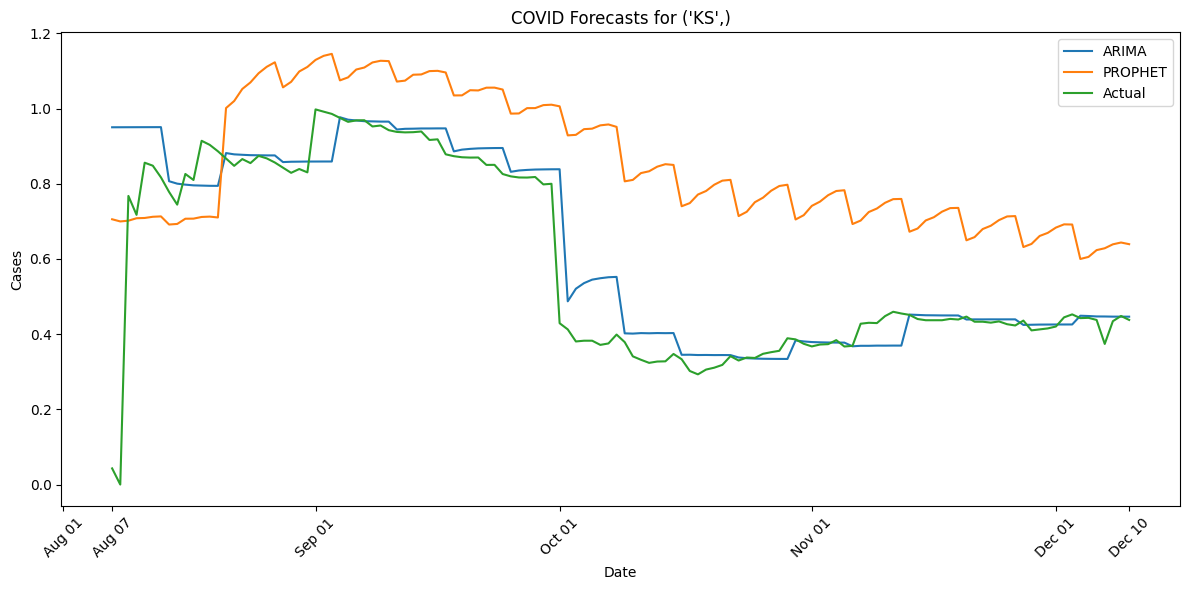

16:21:56 - cmdstanpy - INFO - Chain [1] start processing
16:21:56 - cmdstanpy - INFO - Chain [1] done processing


Average MSE loss ARIMA: 0.019490279500287682
Average MAE loss ARIMA: 0.060486712405670426
Average MSE loss PROPHET: 0.10780386532089348
Average MAE loss PROPHET: 0.28536601775978143
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


16:21:56 - cmdstanpy - INFO - Chain [1] start processing
16:21:56 - cmdstanpy - INFO - Chain [1] done processing
16:21:57 - cmdstanpy - INFO - Chain [1] start processing
16:21:57 - cmdstanpy - INFO - Chain [1] done processing
16:21:57 - cmdstanpy - INFO - Chain [1] start processing
16:21:57 - cmdstanpy - INFO - Chain [1] done processing
16:21:57 - cmdstanpy - INFO - Chain [1] start processing
16:21:57 - cmdstanpy - INFO - Chain [1] done processing
16:21:57 - cmdstanpy - INFO - Chain [1] start processing
16:21:57 - cmdstanpy - INFO - Chain [1] done processing
16:21:57 - cmdstanpy - INFO - Chain [1] start processing
16:21:57 - cmdstanpy - INFO - Chain [1] done processing
16:21:57 - cmdstanpy - INFO - Chain [1] start processing
16:21:57 - cmdstanpy - INFO - Chain [1] done processing
16:21:57 - cmdstanpy - INFO - Chain [1] start processing
16:21:57 - cmdstanpy - INFO - Chain [1] done processing
16:21:58 - cmdstanpy - INFO - Chain [1] start processing
16:21:58 - cmdstanpy - INFO - Chain [1]

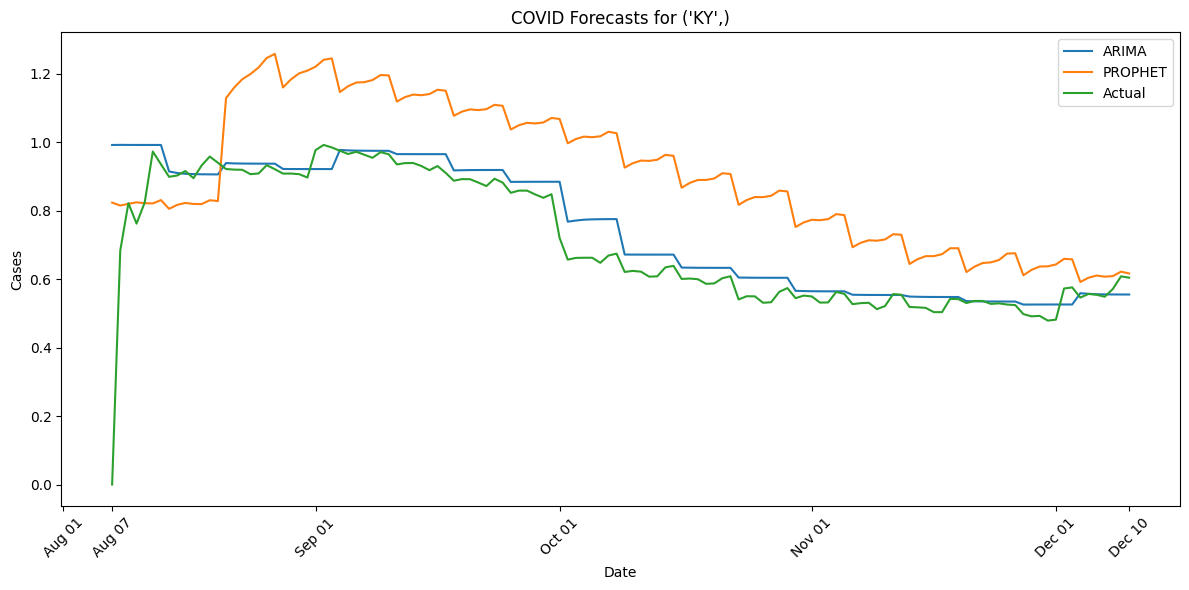

16:27:48 - cmdstanpy - INFO - Chain [1] start processing
16:27:48 - cmdstanpy - INFO - Chain [1] done processing


Average MSE loss ARIMA: 0.012055903586230002
Average MAE loss ARIMA: 0.04938205513903255
Average MSE loss PROPHET: 0.05988329775946387
Average MAE loss PROPHET: 0.21373570569705636
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


16:27:48 - cmdstanpy - INFO - Chain [1] start processing
16:27:48 - cmdstanpy - INFO - Chain [1] done processing
16:27:48 - cmdstanpy - INFO - Chain [1] start processing
16:27:48 - cmdstanpy - INFO - Chain [1] done processing
16:27:48 - cmdstanpy - INFO - Chain [1] start processing
16:27:48 - cmdstanpy - INFO - Chain [1] done processing
16:27:48 - cmdstanpy - INFO - Chain [1] start processing
16:27:48 - cmdstanpy - INFO - Chain [1] done processing
16:27:48 - cmdstanpy - INFO - Chain [1] start processing
16:27:48 - cmdstanpy - INFO - Chain [1] done processing
16:27:48 - cmdstanpy - INFO - Chain [1] start processing
16:27:48 - cmdstanpy - INFO - Chain [1] done processing
16:27:48 - cmdstanpy - INFO - Chain [1] start processing
16:27:48 - cmdstanpy - INFO - Chain [1] done processing
16:27:49 - cmdstanpy - INFO - Chain [1] start processing
16:27:49 - cmdstanpy - INFO - Chain [1] done processing
16:27:49 - cmdstanpy - INFO - Chain [1] start processing
16:27:49 - cmdstanpy - INFO - Chain [1]

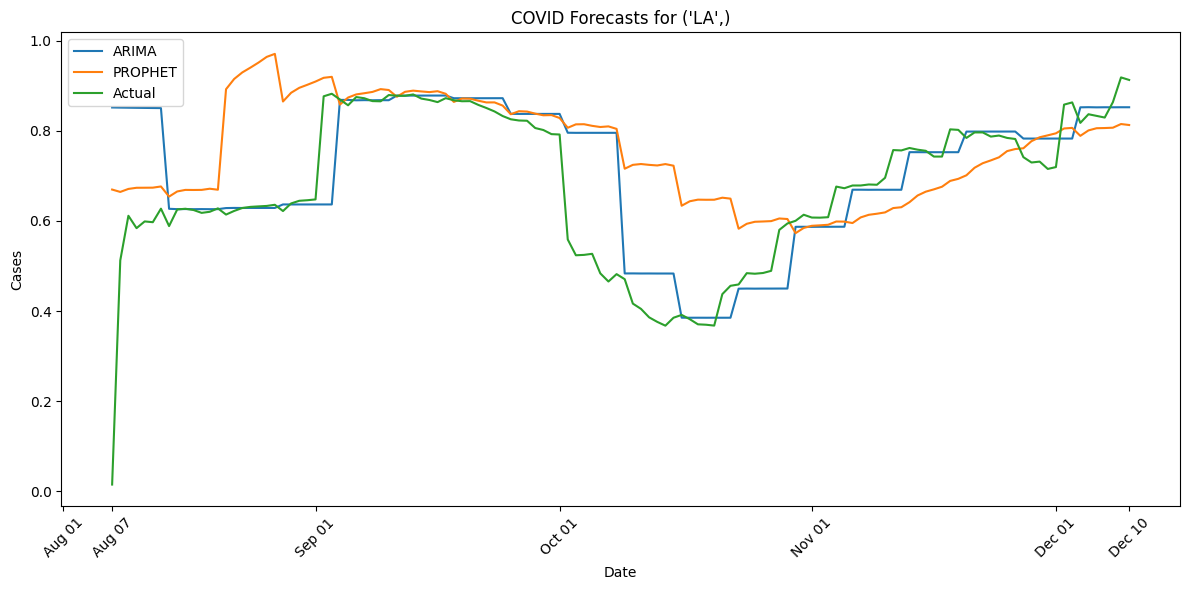

17:52:01 - cmdstanpy - INFO - Chain [1] start processing
17:52:02 - cmdstanpy - INFO - Chain [1] done processing


Average MSE loss ARIMA: 0.020463300542333692
Average MAE loss ARIMA: 0.07014169607498827
Average MSE loss PROPHET: 0.043606330580158184
Average MAE loss PROPHET: 0.16099096242200572
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


17:52:02 - cmdstanpy - INFO - Chain [1] start processing
17:52:02 - cmdstanpy - INFO - Chain [1] done processing
17:52:02 - cmdstanpy - INFO - Chain [1] start processing
17:52:02 - cmdstanpy - INFO - Chain [1] done processing
17:52:02 - cmdstanpy - INFO - Chain [1] start processing
17:52:02 - cmdstanpy - INFO - Chain [1] done processing
17:52:02 - cmdstanpy - INFO - Chain [1] start processing
17:52:02 - cmdstanpy - INFO - Chain [1] done processing
17:52:02 - cmdstanpy - INFO - Chain [1] start processing
17:52:02 - cmdstanpy - INFO - Chain [1] done processing
17:52:02 - cmdstanpy - INFO - Chain [1] start processing
17:52:02 - cmdstanpy - INFO - Chain [1] done processing
17:52:02 - cmdstanpy - INFO - Chain [1] start processing
17:52:03 - cmdstanpy - INFO - Chain [1] done processing
17:52:03 - cmdstanpy - INFO - Chain [1] start processing
17:52:03 - cmdstanpy - INFO - Chain [1] done processing
17:52:03 - cmdstanpy - INFO - Chain [1] start processing
17:52:03 - cmdstanpy - INFO - Chain [1]

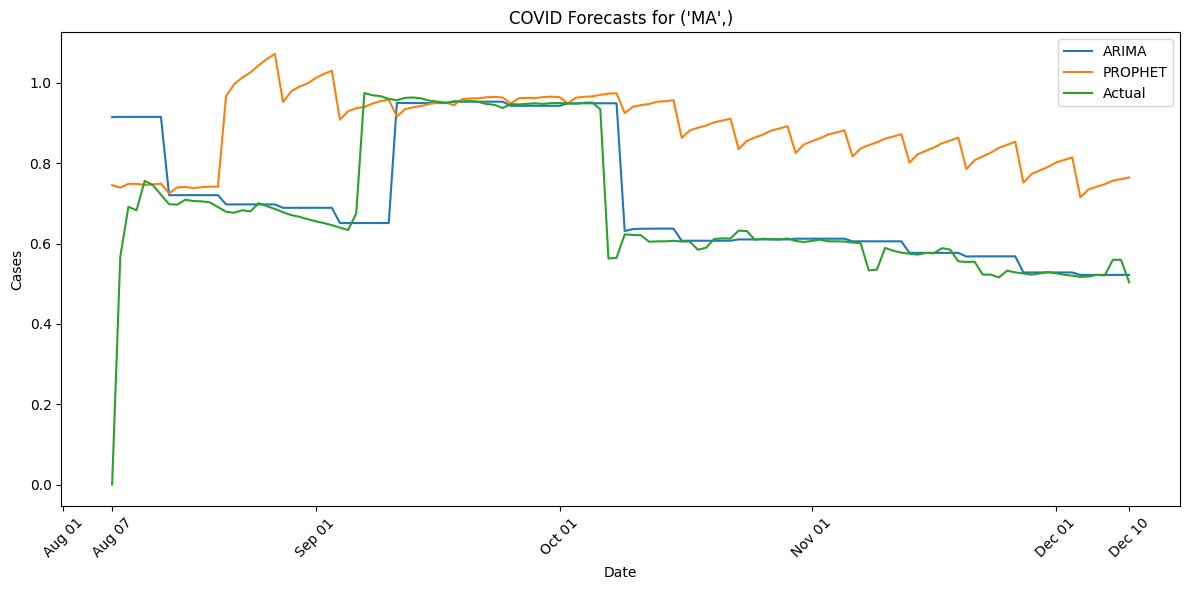

18:12:29 - cmdstanpy - INFO - Chain [1] start processing
18:12:29 - cmdstanpy - INFO - Chain [1] done processing


Average MSE loss ARIMA: 0.017902417698017245
Average MAE loss ARIMA: 0.0503501997294804
Average MSE loss PROPHET: 0.070778001517237
Average MAE loss PROPHET: 0.229611862802767
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


18:12:36 - cmdstanpy - INFO - Chain [1] start processing
18:12:37 - cmdstanpy - INFO - Chain [1] done processing
18:12:37 - cmdstanpy - INFO - Chain [1] start processing
18:12:37 - cmdstanpy - INFO - Chain [1] done processing
18:12:37 - cmdstanpy - INFO - Chain [1] start processing
18:12:37 - cmdstanpy - INFO - Chain [1] done processing
18:12:37 - cmdstanpy - INFO - Chain [1] start processing
18:12:37 - cmdstanpy - INFO - Chain [1] done processing
18:12:38 - cmdstanpy - INFO - Chain [1] start processing
18:12:38 - cmdstanpy - INFO - Chain [1] done processing
18:12:38 - cmdstanpy - INFO - Chain [1] start processing
18:12:38 - cmdstanpy - INFO - Chain [1] done processing
18:12:38 - cmdstanpy - INFO - Chain [1] start processing
18:12:38 - cmdstanpy - INFO - Chain [1] done processing
18:12:38 - cmdstanpy - INFO - Chain [1] start processing
18:12:38 - cmdstanpy - INFO - Chain [1] done processing
18:12:38 - cmdstanpy - INFO - Chain [1] start processing
18:12:38 - cmdstanpy - INFO - Chain [1]

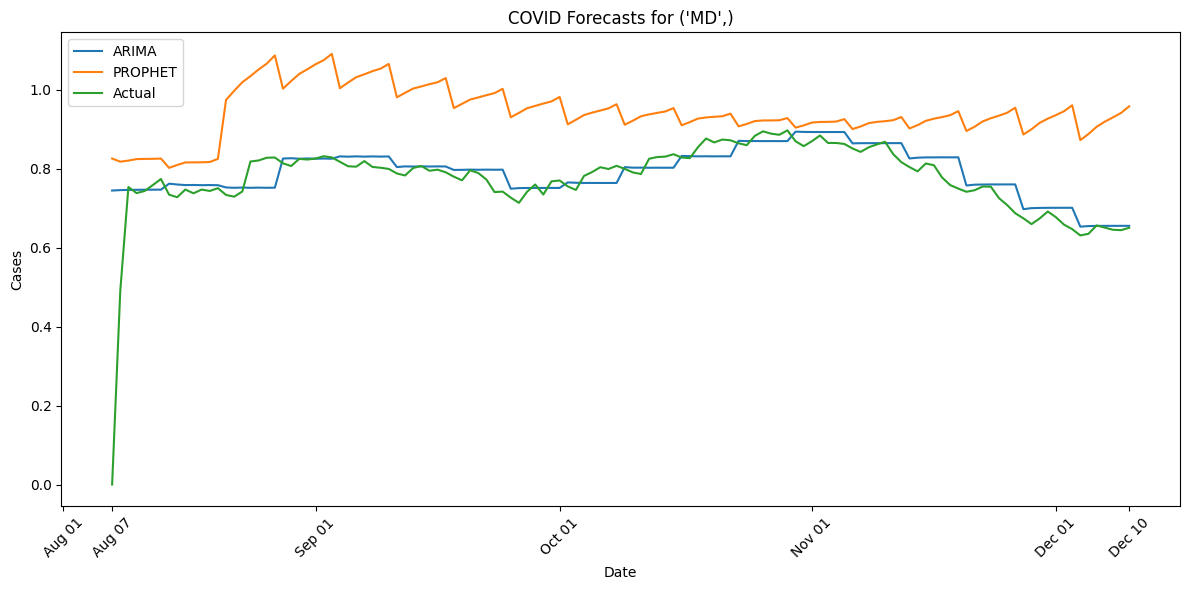

18:13:49 - cmdstanpy - INFO - Chain [1] start processing
18:13:49 - cmdstanpy - INFO - Chain [1] done processing


Average MSE loss ARIMA: 0.007662017600582292
Average MAE loss ARIMA: 0.04003329956968944
Average MSE loss PROPHET: 0.056067900893066465
Average MAE loss PROPHET: 0.19359826349033107
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


18:13:49 - cmdstanpy - INFO - Chain [1] start processing
18:13:49 - cmdstanpy - INFO - Chain [1] done processing
18:13:49 - cmdstanpy - INFO - Chain [1] start processing
18:13:49 - cmdstanpy - INFO - Chain [1] done processing
18:13:50 - cmdstanpy - INFO - Chain [1] start processing
18:13:50 - cmdstanpy - INFO - Chain [1] done processing
18:13:50 - cmdstanpy - INFO - Chain [1] start processing
18:13:50 - cmdstanpy - INFO - Chain [1] done processing
18:13:50 - cmdstanpy - INFO - Chain [1] start processing
18:13:50 - cmdstanpy - INFO - Chain [1] done processing
18:13:50 - cmdstanpy - INFO - Chain [1] start processing
18:13:50 - cmdstanpy - INFO - Chain [1] done processing
18:13:50 - cmdstanpy - INFO - Chain [1] start processing
18:13:50 - cmdstanpy - INFO - Chain [1] done processing
18:13:50 - cmdstanpy - INFO - Chain [1] start processing
18:13:50 - cmdstanpy - INFO - Chain [1] done processing
18:13:50 - cmdstanpy - INFO - Chain [1] start processing
18:13:50 - cmdstanpy - INFO - Chain [1]

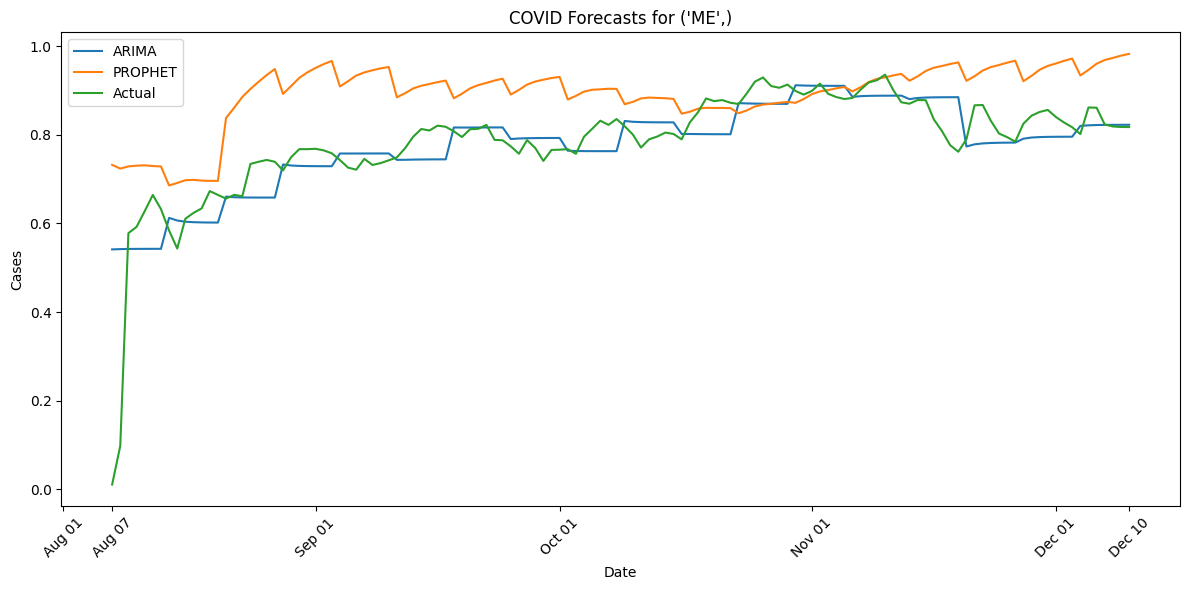

18:14:35 - cmdstanpy - INFO - Chain [1] start processing
18:14:35 - cmdstanpy - INFO - Chain [1] done processing


Average MSE loss ARIMA: 0.009758769526625197
Average MAE loss ARIMA: 0.05868684196410238
Average MSE loss PROPHET: 0.03491642806630635
Average MAE loss PROPHET: 0.14630125255653906
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


18:14:35 - cmdstanpy - INFO - Chain [1] start processing
18:14:35 - cmdstanpy - INFO - Chain [1] done processing
18:14:35 - cmdstanpy - INFO - Chain [1] start processing
18:14:35 - cmdstanpy - INFO - Chain [1] done processing
18:14:35 - cmdstanpy - INFO - Chain [1] start processing
18:14:35 - cmdstanpy - INFO - Chain [1] done processing
18:14:36 - cmdstanpy - INFO - Chain [1] start processing
18:14:36 - cmdstanpy - INFO - Chain [1] done processing
18:14:36 - cmdstanpy - INFO - Chain [1] start processing
18:14:36 - cmdstanpy - INFO - Chain [1] done processing
18:14:36 - cmdstanpy - INFO - Chain [1] start processing
18:14:36 - cmdstanpy - INFO - Chain [1] done processing
18:14:36 - cmdstanpy - INFO - Chain [1] start processing
18:14:36 - cmdstanpy - INFO - Chain [1] done processing
18:14:36 - cmdstanpy - INFO - Chain [1] start processing
18:14:36 - cmdstanpy - INFO - Chain [1] done processing
18:14:36 - cmdstanpy - INFO - Chain [1] start processing
18:14:36 - cmdstanpy - INFO - Chain [1]

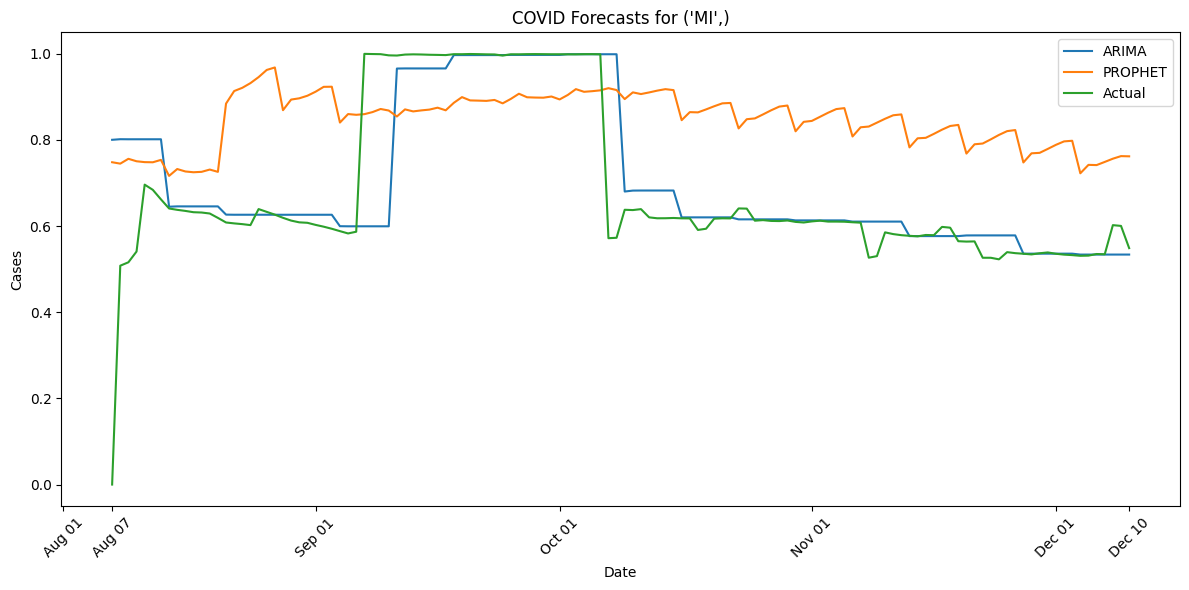

18:18:44 - cmdstanpy - INFO - Chain [1] start processing
18:18:44 - cmdstanpy - INFO - Chain [1] done processing


Average MSE loss ARIMA: 0.016067198497494585
Average MAE loss ARIMA: 0.05087158663576331
Average MSE loss PROPHET: 0.05591788323074807
Average MAE loss PROPHET: 0.21437428550607326
Average MSE loss LSTM: 
Average MAE loss LSTM: 
Average MSE loss GCN: 
Average MAE loss GCN: 


18:18:44 - cmdstanpy - INFO - Chain [1] start processing
18:18:44 - cmdstanpy - INFO - Chain [1] done processing
18:18:44 - cmdstanpy - INFO - Chain [1] start processing
18:18:45 - cmdstanpy - INFO - Chain [1] done processing
18:18:45 - cmdstanpy - INFO - Chain [1] start processing
18:18:45 - cmdstanpy - INFO - Chain [1] done processing
18:18:45 - cmdstanpy - INFO - Chain [1] start processing
18:18:45 - cmdstanpy - INFO - Chain [1] done processing
18:18:45 - cmdstanpy - INFO - Chain [1] start processing
18:18:45 - cmdstanpy - INFO - Chain [1] done processing
18:18:45 - cmdstanpy - INFO - Chain [1] start processing
18:18:45 - cmdstanpy - INFO - Chain [1] done processing
18:18:45 - cmdstanpy - INFO - Chain [1] start processing
18:18:45 - cmdstanpy - INFO - Chain [1] done processing
18:18:45 - cmdstanpy - INFO - Chain [1] start processing
18:18:46 - cmdstanpy - INFO - Chain [1] done processing
18:18:46 - cmdstanpy - INFO - Chain [1] start processing
18:18:46 - cmdstanpy - INFO - Chain [1]

KeyboardInterrupt: 

In [ ]:
#test_dates = dftest.columns.to_list()[4:]
#results = forecast_all_models(df, test_dates=test_dates)